In [ ]:
import librosa
import math
import os
import re

import numpy as np


class GenreFeatureData:

    "Music audio features for genre classification"
    hop_length = None
    genre_list = [
        "classical",
        "country",
        "disco",
        "hiphop",
        "jazz",
        "metal",
        "pop",
        "reggae",
    ]

    dir_trainfolder = "./gtzan/_train"
    dir_devfolder = "./gtzan/_validation"
    dir_testfolder = "./gtzan/_test"
    dir_all_files = "./gtzan"

    train_X_preprocessed_data = "./gtzan/data_train_input.npy"
    train_Y_preprocessed_data = "./gtzan/data_train_target.npy"
    dev_X_preprocessed_data = "./gtzan/data_validation_input.npy"
    dev_Y_preprocessed_data = "./gtzan/data_validation_target.npy"
    test_X_preprocessed_data = "./gtzan/data_test_input.npy"
    test_Y_preprocessed_data = "./gtzan/data_test_target.npy"

    train_X = train_Y = None
    dev_X = dev_Y = None
    test_X = test_Y = None

    def __init__(self):
        self.hop_length = 512

        self.timeseries_length_list = []
        self.trainfiles_list = self.path_to_audiofiles(self.dir_trainfolder)
        self.devfiles_list = self.path_to_audiofiles(self.dir_devfolder)
        self.testfiles_list = self.path_to_audiofiles(self.dir_testfolder)

        self.all_files_list = []
        self.all_files_list.extend(self.trainfiles_list)
        self.all_files_list.extend(self.devfiles_list)
        self.all_files_list.extend(self.testfiles_list)

        # compute minimum timeseries length, slow to compute, caching pre-computed value of 1290
        # self.precompute_min_timeseries_len()
        # print("min(self.timeseries_length_list) ==" + str(min(self.timeseries_length_list)))
        # self.timeseries_length = min(self.timeseries_length_list)

        self.timeseries_length = (
            128
        )   # sequence length == 128, default fftsize == 2048 & hop == 512 @ SR of 22050
        #  equals 128 overlapped windows that cover approx ~3.065 seconds of audio, which is a bit small!

    def load_preprocess_data(self):
        print("[DEBUG] total number of files: " + str(len(self.timeseries_length_list)))

        # Training set
        self.train_X, self.train_Y = self.extract_audio_features(self.trainfiles_list)
        with open(self.train_X_preprocessed_data, "wb") as f:
            np.save(f, self.train_X)
        with open(self.train_Y_preprocessed_data, "wb") as f:
            self.train_Y = self.one_hot(self.train_Y)
            np.save(f, self.train_Y)

        # Validation set
        self.dev_X, self.dev_Y = self.extract_audio_features(self.devfiles_list)
        with open(self.dev_X_preprocessed_data, "wb") as f:
            np.save(f, self.dev_X)
        with open(self.dev_Y_preprocessed_data, "wb") as f:
            self.dev_Y = self.one_hot(self.dev_Y)
            np.save(f, self.dev_Y)

        # Test set
        self.test_X, self.test_Y = self.extract_audio_features(self.testfiles_list)
        with open(self.test_X_preprocessed_data, "wb") as f:
            np.save(f, self.test_X)
        with open(self.test_Y_preprocessed_data, "wb") as f:
            self.test_Y = self.one_hot(self.test_Y)
            np.save(f, self.test_Y)

    def load_deserialize_data(self):

        self.train_X = np.load(self.train_X_preprocessed_data)
        self.train_Y = np.load(self.train_Y_preprocessed_data)

        self.dev_X = np.load(self.dev_X_preprocessed_data)
        self.dev_Y = np.load(self.dev_Y_preprocessed_data)

        self.test_X = np.load(self.test_X_preprocessed_data)
        self.test_Y = np.load(self.test_Y_preprocessed_data)

    def precompute_min_timeseries_len(self):
        for file in self.all_files_list:
            print("Loading " + str(file))
            y, sr = librosa.load(file)
            self.timeseries_length_list.append(math.ceil(len(y) / self.hop_length))

    def extract_audio_features(self, list_of_audiofiles):

        data = np.zeros((len(list_of_audiofiles), self.timeseries_length, 33), dtype=np.float64)
        
        target = []

        for i, file in enumerate(list_of_audiofiles):
            y, sr = librosa.load(file)
            mfcc = librosa.feature.mfcc(
                y=y, sr=sr, hop_length=self.hop_length, n_mfcc=13
            )
            spectral_center = librosa.feature.spectral_centroid(
                y=y, sr=sr, hop_length=self.hop_length
            )
            chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=self.hop_length)
            spectral_contrast = librosa.feature.spectral_contrast(
                y=y, sr=sr, hop_length=self.hop_length
            )

            splits = re.split("[ .]", file)
            genre = re.split("[ /]", splits[1])[3]
            target.append(genre)

            data[i, :, 0:13] = mfcc.T[0:self.timeseries_length, :]
            data[i, :, 13:14] = spectral_center.T[0:self.timeseries_length, :]
            data[i, :, 14:26] = chroma.T[0:self.timeseries_length, :]
            data[i, :, 26:33] = spectral_contrast.T[0:self.timeseries_length, :]

            print(
                "Extracted features audio track %i of %i."
                % (i + 1, len(list_of_audiofiles))
            )

        return data, np.expand_dims(np.asarray(target), axis=1)

    def one_hot(self, Y_genre_strings):
        y_one_hot = np.zeros((Y_genre_strings.shape[0], len(self.genre_list)))
        for i, genre_string in enumerate(Y_genre_strings):
            index = self.genre_list.index(genre_string)
            y_one_hot[i, index] = 1
        return y_one_hot

    @staticmethod
    def path_to_audiofiles(dir_folder):
        list_of_audio = []
        for file in os.listdir(dir_folder):
            if file.endswith(".au"):
                directory = "%s/%s" % (dir_folder, file)
                list_of_audio.append(directory)
        return list_of_audio

In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from GenreFeatureData import (
    GenreFeatureData,
)  # local python class with Audio feature extraction (librosa)

genre_features = GenreFeatureData()

# if all of the preprocessed files do not exist, regenerate them all for self-consistency
if (
    os.path.isfile(genre_features.train_X_preprocessed_data)
    and os.path.isfile(genre_features.train_Y_preprocessed_data)
    and os.path.isfile(genre_features.dev_X_preprocessed_data)
    and os.path.isfile(genre_features.dev_Y_preprocessed_data)
    and os.path.isfile(genre_features.test_X_preprocessed_data)
    and os.path.isfile(genre_features.test_Y_preprocessed_data)
):
    print("Preprocessed files exist, deserializing npy files")
    genre_features.load_deserialize_data()
else:
    print("Preprocessing raw audio files")
    genre_features.load_preprocess_data()

train_X = torch.from_numpy(genre_features.train_X).type(torch.Tensor)
dev_X = torch.from_numpy(genre_features.dev_X).type(torch.Tensor)
test_X = torch.from_numpy(genre_features.test_X).type(torch.Tensor)

# Targets is a long tensor of size (N,) which tells the true class of the sample.
train_Y = torch.from_numpy(genre_features.train_Y).type(torch.LongTensor)
dev_Y = torch.from_numpy(genre_features.dev_Y).type(torch.LongTensor)
test_Y = torch.from_numpy(genre_features.test_Y).type(torch.LongTensor)

# Convert {training, test} torch.Tensors
print("Training X shape: " + str(genre_features.train_X.shape))
print("Training Y shape: " + str(genre_features.train_Y.shape))
print("Validation X shape: " + str(genre_features.dev_X.shape))
print("Validation Y shape: " + str(genre_features.dev_Y.shape))
print("Test X shape: " + str(genre_features.test_X.shape))
print("Test Y shape: " + str(genre_features.test_Y.shape))

# class definition
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=8, num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # setup LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # setup output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        return (
            torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
            torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
        )

    def forward(self, input):
        # lstm step => then ONLY take the sequence's final timetep to pass into the linear/dense layer
        # Note: lstm_out contains outputs for every step of the sequence we are looping over (for BPTT)
        # but we just need the output of the last step of the sequence, aka lstm_out[-1]
        lstm_out, hidden = self.lstm(input)
        logits = self.linear(lstm_out[-1])
        genre_scores = F.log_softmax(logits, dim=1)
        return genre_scores

    def get_accuracy(self, logits, target):
        """ compute accuracy for training round """
        corrects = (
            torch.max(logits, 1)[1].view(target.size()).data == target.data
        ).sum()
        accuracy = 100.0 * corrects / self.batch_size
        return accuracy.item()


batch_size = 35  # num of training examples per minibatch
num_epochs = 400

# Define model
print("Build LSTM RNN model ...")
model = LSTM( input_dim=33, hidden_dim=128, batch_size=batch_size, output_dim=8, num_layers=2 )

loss_function = nn.NLLLoss()  # expects ouputs from LogSoftmax

optimizer = optim.Adam(model.parameters(), lr=0.001)

train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print("\nTraining on GPU")
else:
    print("\nNo GPU, training on CPU")

# all training data (epoch) / batch_size == num_batches (12)
num_batches = int(train_X.shape[0] / batch_size)
num_dev_batches = int(dev_X.shape[0] / batch_size)

val_loss_list, val_accuracy_list, epoch_list = [], [], []

print("Training ...")
for epoch in range(num_epochs):

    train_running_loss, train_acc = 0.0, 0.0

    # Init hidden state - if you don't want a stateful LSTM (between epochs)
    model.hidden = model.init_hidden()
    for i in range(num_batches):

        # zero out gradient, so they don't accumulate btw epochs
        model.zero_grad()

        # train_X shape: (total # of training examples, sequence_length, input_dim)
        # train_Y shape: (total # of training examples, # output classes)
        #
        # Slice out local minibatches & labels => Note that we *permute* the local minibatch to
        # match the PyTorch expected input tensor format of (sequence_length, batch size, input_dim)
        X_local_minibatch, y_local_minibatch = (
            train_X[i * batch_size : (i + 1) * batch_size,],
            train_Y[i * batch_size : (i + 1) * batch_size,],
        )

        # Reshape input & targets to "match" what the loss_function wants
        X_local_minibatch = X_local_minibatch.permute(1, 0, 2)

        # NLLLoss does not expect a one-hot encoded vector as the target, but class indices
        y_local_minibatch = torch.max(y_local_minibatch, 1)[1]

        y_pred = model(X_local_minibatch)                # fwd the bass (forward pass)
        loss = loss_function(y_pred, y_local_minibatch)  # compute loss
        loss.backward()                                  # reeeeewind (backward pass)
        optimizer.step()                                 # parameter update

        train_running_loss += loss.detach().item()       # unpacks the tensor into a scalar value
        train_acc += model.get_accuracy(y_pred, y_local_minibatch)

    print(
        "Epoch:  %d | NLLoss: %.4f | Train Accuracy: %.2f"
        % (epoch, train_running_loss / num_batches, train_acc / num_batches)
    )

    print("Validation ...")  # should this be done every N epochs
    if epoch % 10 == 0:
        val_running_loss, val_acc = 0.0, 0.0

        # Compute validation loss, accuracy. Use torch.no_grad() & model.eval()
        with torch.no_grad():
            model.eval()

            model.hidden = model.init_hidden()
            for i in range(num_dev_batches):
                X_local_validation_minibatch, y_local_validation_minibatch = (
                    dev_X[i * batch_size : (i + 1) * batch_size,],
                    dev_Y[i * batch_size : (i + 1) * batch_size,],
                )
                X_local_minibatch = X_local_validation_minibatch.permute(1, 0, 2)
                y_local_minibatch = torch.max(y_local_validation_minibatch, 1)[1]

                y_pred = model(X_local_minibatch)
                val_loss = loss_function(y_pred, y_local_minibatch)

                val_running_loss += (
                    val_loss.detach().item()
                )  # unpacks the tensor into a scalar value
                val_acc += model.get_accuracy(y_pred, y_local_minibatch)

            model.train()  # reset to train mode after iterationg through validation data
            print(
                "Epoch:  %d | NLLoss: %.4f | Train Accuracy: %.2f | Val Loss %.4f  | Val Accuracy: %.2f"
                % (
                    epoch,
                    train_running_loss / num_batches,
                    train_acc / num_batches,
                    val_running_loss / num_dev_batches,
                    val_acc / num_dev_batches,
                )
            )

        epoch_list.append(epoch)
        val_accuracy_list.append(val_acc / num_dev_batches)
        val_loss_list.append(val_running_loss / num_dev_batches)

# visualization loss
plt.plot(epoch_list, val_loss_list)
plt.xlabel("# of epochs")
plt.ylabel("Loss")
plt.title("LSTM: Loss vs # epochs")
plt.show()

# visualization accuracy
plt.plot(epoch_list, val_accuracy_list, color="red")
plt.xlabel("# of epochs")
plt.ylabel("Accuracy")
plt.title("LSTM: Accuracy vs # epochs")
# plt.savefig('graph.png')
plt.show()

print("Testing ...")

# File issue to add pytorch data loaders, is there an open GTZAN pytorch dataloader?
# where to add them? keras or pytorch data repos?

In [ ]:
import librosa
import math
import os
import re

import numpy as np


class GenreFeatureData:

    "Music audio features for genre classification"
    hop_length = None
    genre_list = [
        "classical",
        "country",
        "disco",
        "hiphop",
        "jazz",
        "metal",
        "pop",
        "reggae",
    ]

    dir_trainfolder = "./gtzan/_train"
    dir_devfolder = "./gtzan/_validation"
    dir_testfolder = "./gtzan/_test"
    dir_all_files = "./gtzan"

    train_X_preprocessed_data = "./gtzan/data_train_input.npy"
    train_Y_preprocessed_data = "./gtzan/data_train_target.npy"
    dev_X_preprocessed_data = "./gtzan/data_validation_input.npy"
    dev_Y_preprocessed_data = "./gtzan/data_validation_target.npy"
    test_X_preprocessed_data = "./gtzan/data_test_input.npy"
    test_Y_preprocessed_data = "./gtzan/data_test_target.npy"

    train_X = train_Y = None
    dev_X = dev_Y = None
    test_X = test_Y = None

    def __init__(self):
        self.hop_length = 512

        self.timeseries_length_list = []
        self.trainfiles_list = self.path_to_audiofiles(self.dir_trainfolder)
        self.devfiles_list = self.path_to_audiofiles(self.dir_devfolder)
        self.testfiles_list = self.path_to_audiofiles(self.dir_testfolder)

        self.all_files_list = []
        self.all_files_list.extend(self.trainfiles_list)
        self.all_files_list.extend(self.devfiles_list)
        self.all_files_list.extend(self.testfiles_list)

        # compute minimum timeseries length, slow to compute, caching pre-computed value of 1290
        # self.precompute_min_timeseries_len()
        # print("min(self.timeseries_length_list) ==" + str(min(self.timeseries_length_list)))
        # self.timeseries_length = min(self.timeseries_length_list)

        self.timeseries_length = (
            128
        )   # sequence length == 128, default fftsize == 2048 & hop == 512 @ SR of 22050
        #  equals 128 overlapped windows that cover approx ~3.065 seconds of audio, which is a bit small!

    def load_preprocess_data(self):
        print("[DEBUG] total number of files: " + str(len(self.timeseries_length_list)))

        # Training set
        self.train_X, self.train_Y = self.extract_audio_features(self.trainfiles_list)
        with open(self.train_X_preprocessed_data, "wb") as f:
            np.save(f, self.train_X)
        with open(self.train_Y_preprocessed_data, "wb") as f:
            self.train_Y = self.one_hot(self.train_Y)
            np.save(f, self.train_Y)

        # Validation set
        self.dev_X, self.dev_Y = self.extract_audio_features(self.devfiles_list)
        with open(self.dev_X_preprocessed_data, "wb") as f:
            np.save(f, self.dev_X)
        with open(self.dev_Y_preprocessed_data, "wb") as f:
            self.dev_Y = self.one_hot(self.dev_Y)
            np.save(f, self.dev_Y)

        # Test set
        self.test_X, self.test_Y = self.extract_audio_features(self.testfiles_list)
        with open(self.test_X_preprocessed_data, "wb") as f:
            np.save(f, self.test_X)
        with open(self.test_Y_preprocessed_data, "wb") as f:
            self.test_Y = self.one_hot(self.test_Y)
            np.save(f, self.test_Y)

    def load_deserialize_data(self):

        self.train_X = np.load(self.train_X_preprocessed_data)
        self.train_Y = np.load(self.train_Y_preprocessed_data)

        self.dev_X = np.load(self.dev_X_preprocessed_data)
        self.dev_Y = np.load(self.dev_Y_preprocessed_data)

        self.test_X = np.load(self.test_X_preprocessed_data)
        self.test_Y = np.load(self.test_Y_preprocessed_data)

    def precompute_min_timeseries_len(self):
        for file in self.all_files_list:
            print("Loading " + str(file))
            y, sr = librosa.load(file)
            self.timeseries_length_list.append(math.ceil(len(y) / self.hop_length))

    def extract_audio_features(self, list_of_audiofiles):

        data = np.zeros((len(list_of_audiofiles), self.timeseries_length, 33), dtype=np.float64)
        
        target = []

        for i, file in enumerate(list_of_audiofiles):
            y, sr = librosa.load(file)
            mfcc = librosa.feature.mfcc(
                y=y, sr=sr, hop_length=self.hop_length, n_mfcc=13
            )
            spectral_center = librosa.feature.spectral_centroid(
                y=y, sr=sr, hop_length=self.hop_length
            )
            chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=self.hop_length)
            spectral_contrast = librosa.feature.spectral_contrast(
                y=y, sr=sr, hop_length=self.hop_length
            )

            splits = re.split("[ .]", file)
            genre = re.split("[ /]", splits[1])[3]
            target.append(genre)

            data[i, :, 0:13] = mfcc.T[0:self.timeseries_length, :]
            data[i, :, 13:14] = spectral_center.T[0:self.timeseries_length, :]
            data[i, :, 14:26] = chroma.T[0:self.timeseries_length, :]
            data[i, :, 26:33] = spectral_contrast.T[0:self.timeseries_length, :]

            print(
                "Extracted features audio track %i of %i."
                % (i + 1, len(list_of_audiofiles))
            )

        return data, np.expand_dims(np.asarray(target), axis=1)

    def one_hot(self, Y_genre_strings):
        y_one_hot = np.zeros((Y_genre_strings.shape[0], len(self.genre_list)))
        for i, genre_string in enumerate(Y_genre_strings):
            index = self.genre_list.index(genre_string)
            y_one_hot[i, index] = 1
        return y_one_hot

    @staticmethod
    def path_to_audiofiles(dir_folder):
        list_of_audio = []
        for file in os.listdir(dir_folder):
            if file.endswith(".au"):
                directory = "%s/%s" % (dir_folder, file)
                list_of_audio.append(directory)
        return list_of_audio

In [ ]:
        for epoch in range(0, self.configs.epochs):
            accuracy_sum, loss_sum, n_iter = 0, 0, 0
            while n_iter < self.configs.iterations:
                try:
                    for i, datum in enumerate(self.train_data):
                        outputs, labels, loss = self.train_step(datum)
                        if outputs.shape[0] == 1:
                            continue
                        current_accuracy = calculate_accuracy(outputs, labels)
                        accuracy_sum += current_accuracy
                        loss_sum += loss.data[0]
                        n_iter += 1

                        if n_iter % self.configs.log_interval == 0:
                            self.log_batch_results(current_accuracy, loss.data[0], n_iter, epoch)
                            print("{}.{} complete....".format(epoch, n_iter))
                        if n_iter >= self.configs.iterations:
                            break
                except TypeError:
                    print("Error on Epoch {}...".format(epoch))

            test_acc = self.test_model()
            self.log_epoch_results(accuracy_sum, loss_sum, test_acc, n_iter, epoch)
            self.save_model()
            print("Epoch {} complete.".format(epoch))

In [13]:

# import pytorch library
import torch
  
# create a tensor of size 2 x 4
input_var = torch.randn(2,2,2)
  
# print size
print(input_var.size())
  
print(input_var)
  
# dimensions permuted
input_var = input_var.permute(1,0,2)
  
# print size
print(input_var.size())
  
print(input_var)

torch.Size([2, 2, 2])
tensor([[[ 0.3265,  1.8412],
         [-1.0502,  1.8034]],

        [[-0.4506, -0.6565],
         [-1.8077,  0.4396]]])
torch.Size([2, 2, 2])
tensor([[[ 0.3265,  1.8412],
         [-0.4506, -0.6565]],

        [[-1.0502,  1.8034],
         [-1.8077,  0.4396]]])


Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])


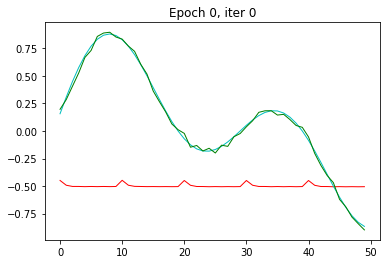

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

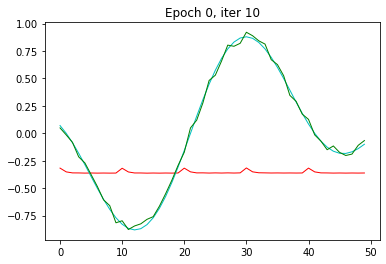

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

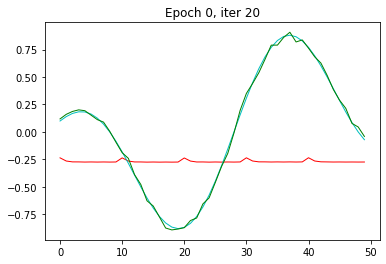

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

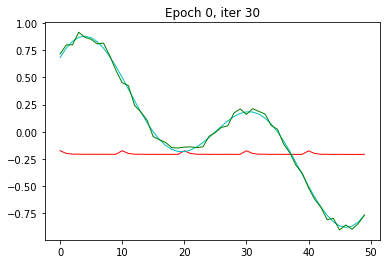

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

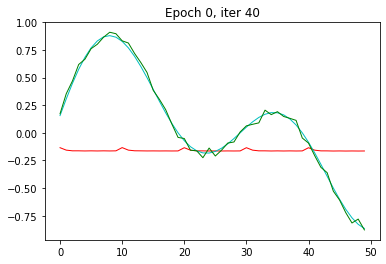

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

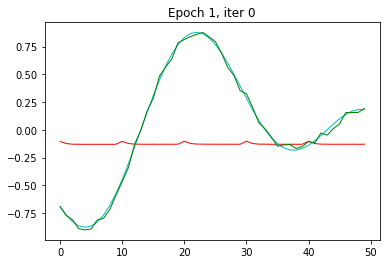

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

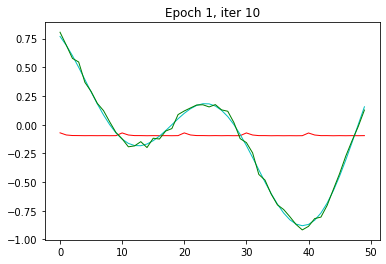

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

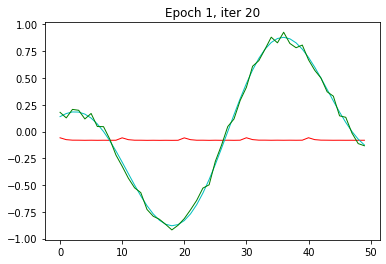

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

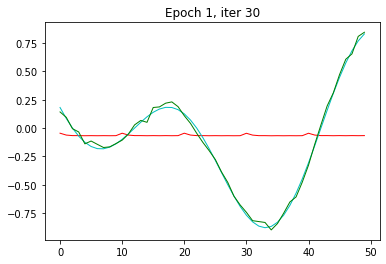

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

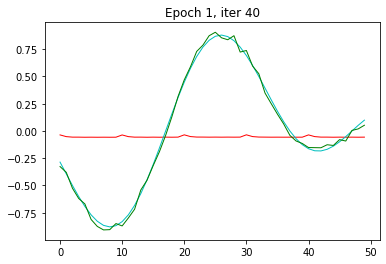

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

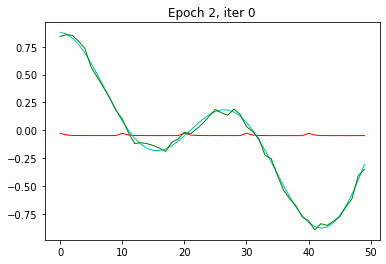

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

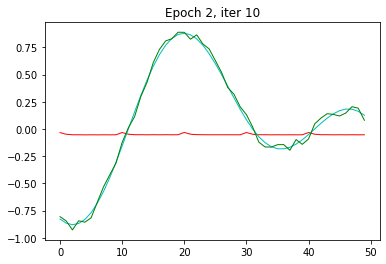

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

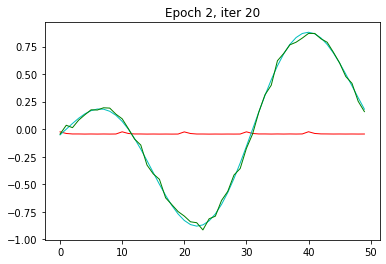

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

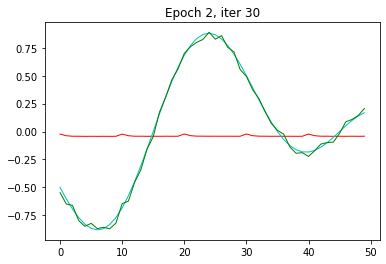

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

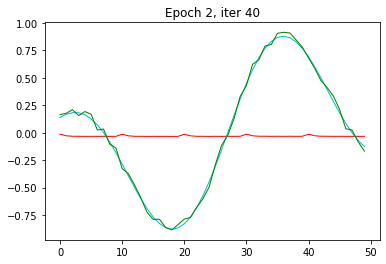

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

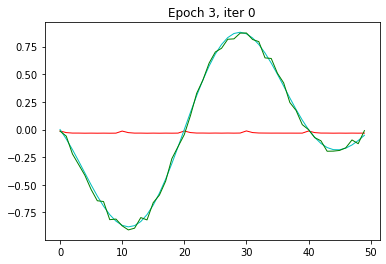

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

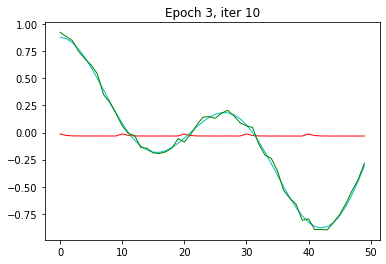

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

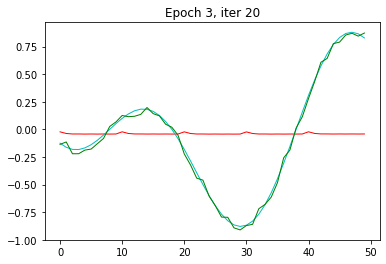

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

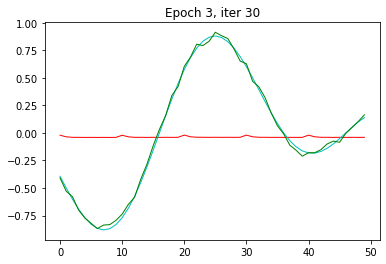

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

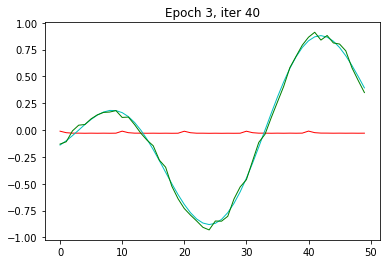

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

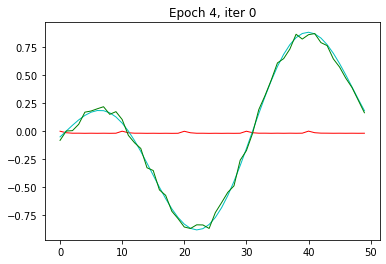

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

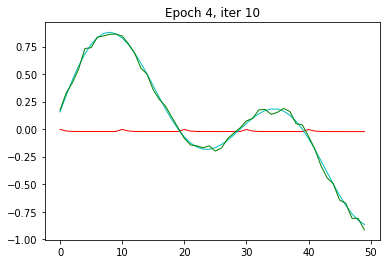

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

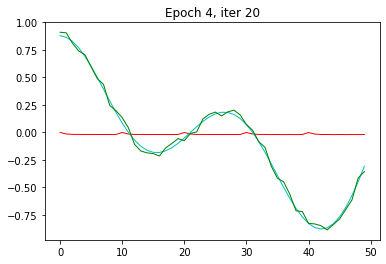

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

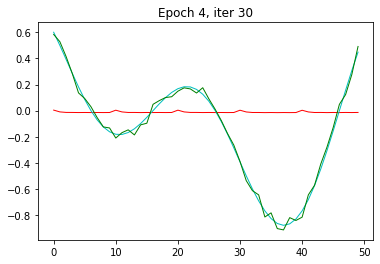

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

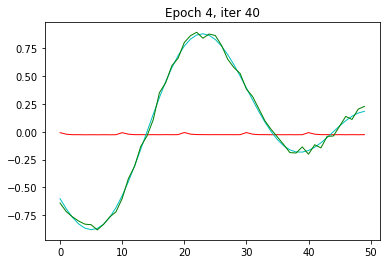

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

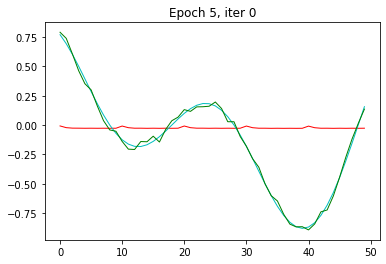

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

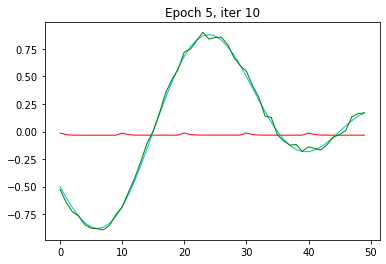

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

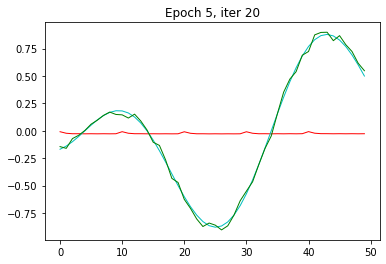

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

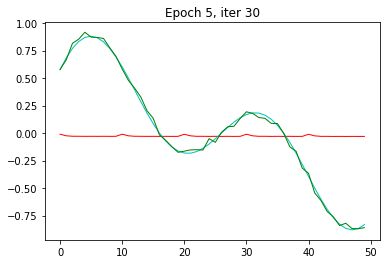

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

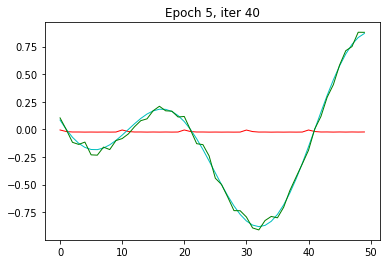

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

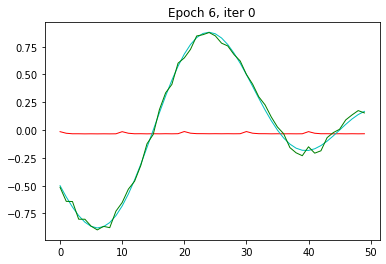

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

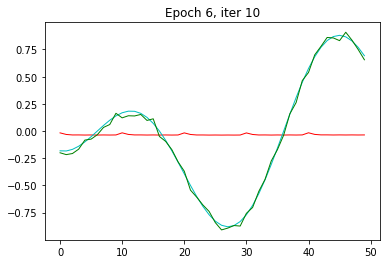

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

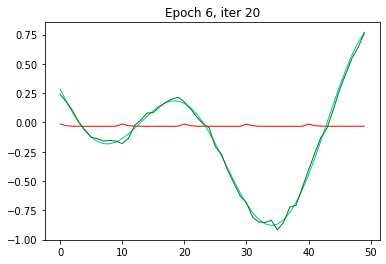

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

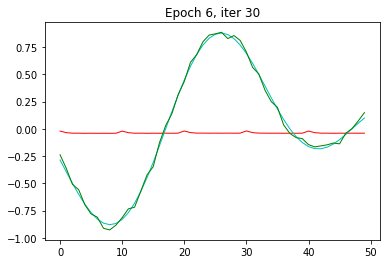

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

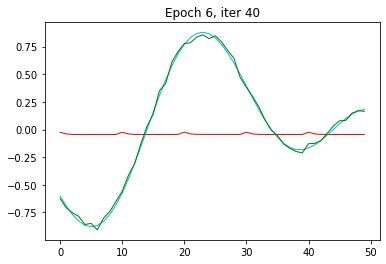

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

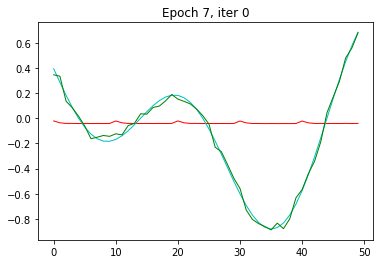

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

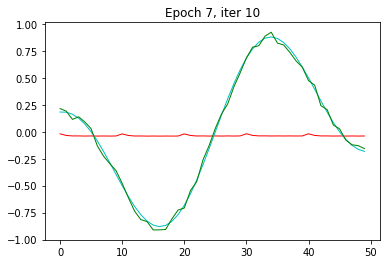

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

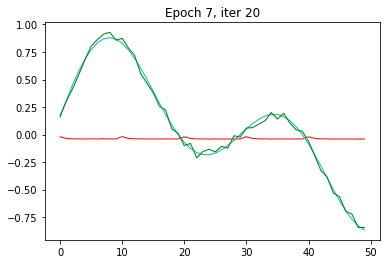

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

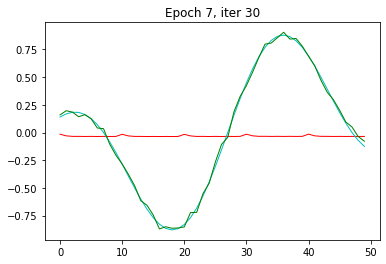

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

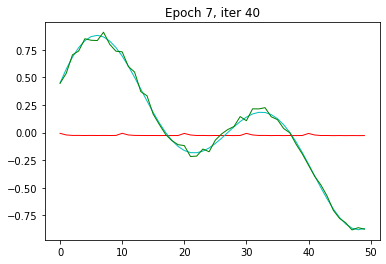

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

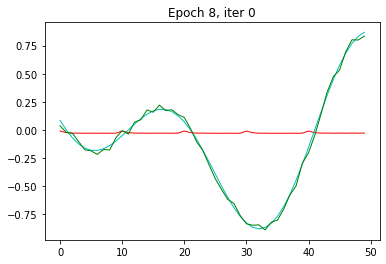

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

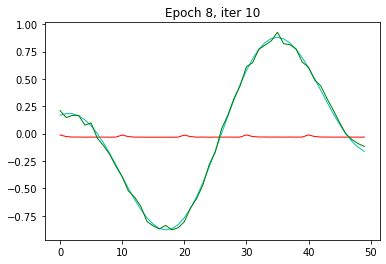

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

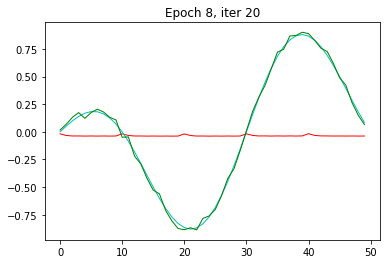

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

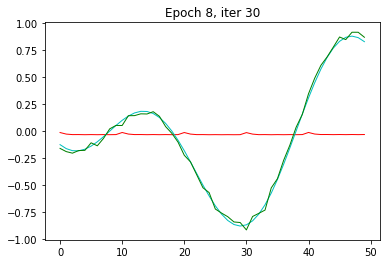

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

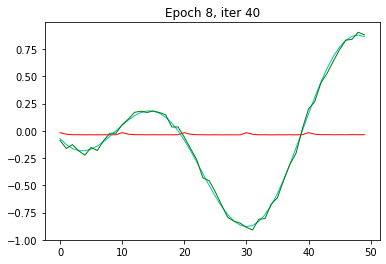

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

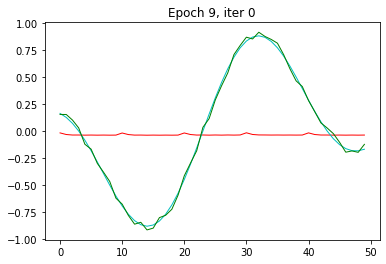

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

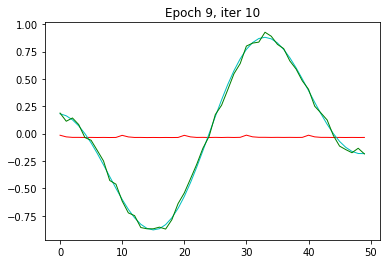

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

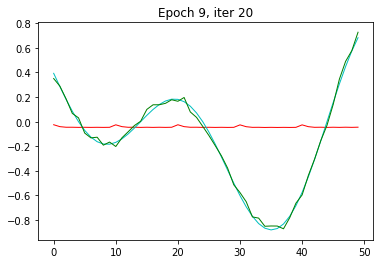

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

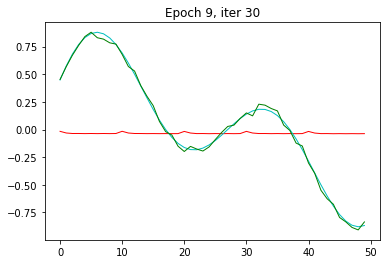

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

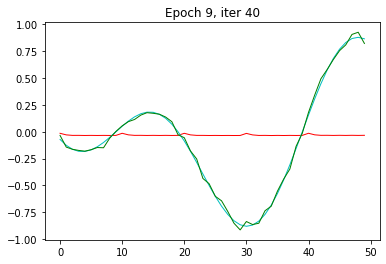

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

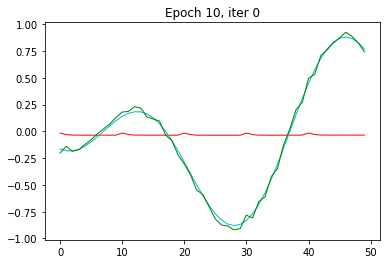

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

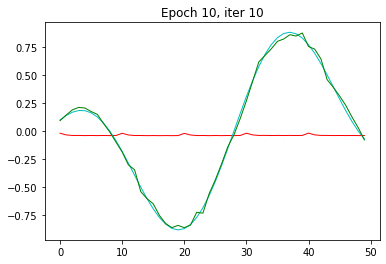

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

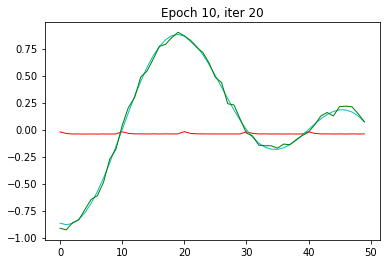

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

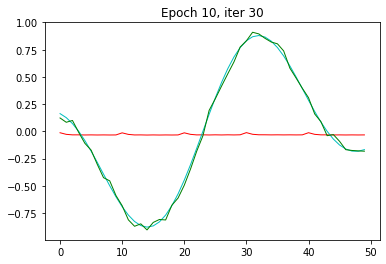

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

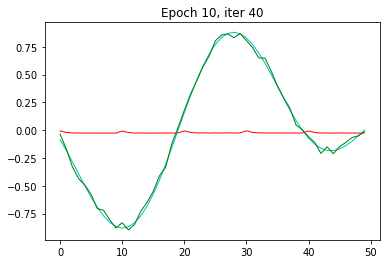

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

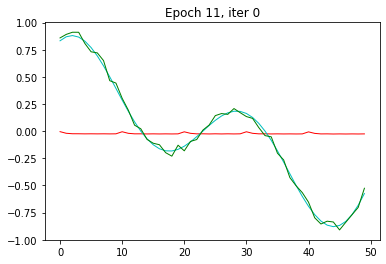

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

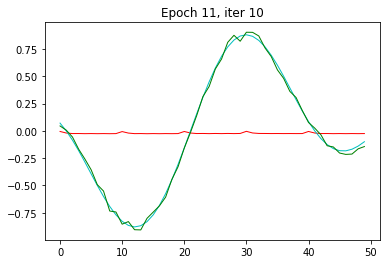

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

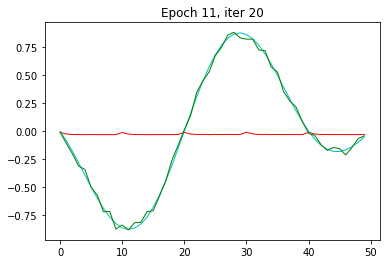

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

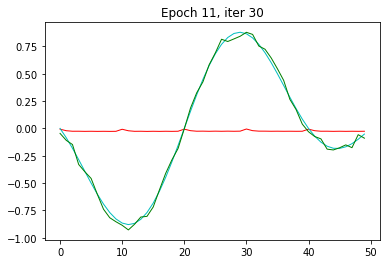

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

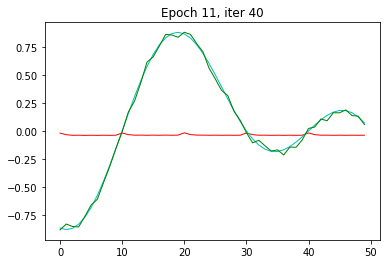

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

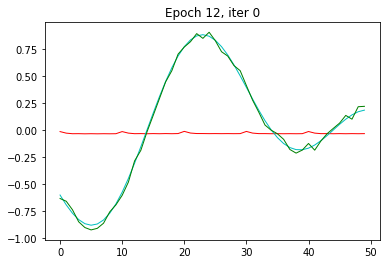

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

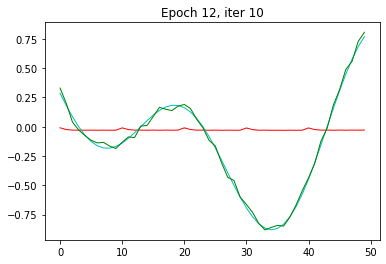

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

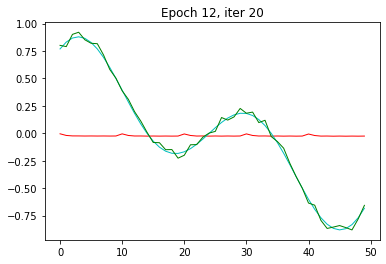

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

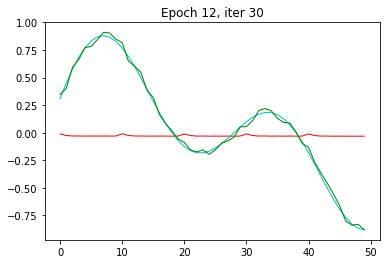

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

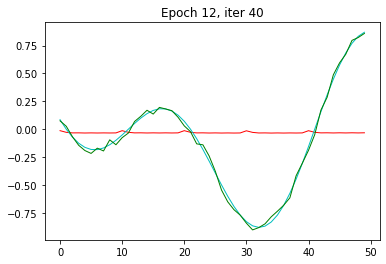

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

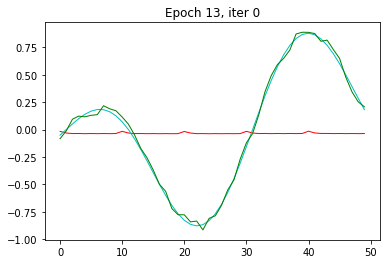

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

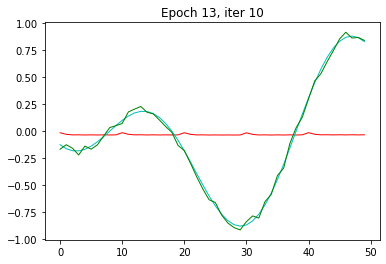

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

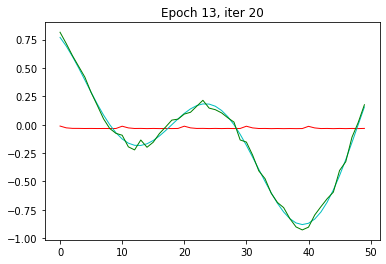

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

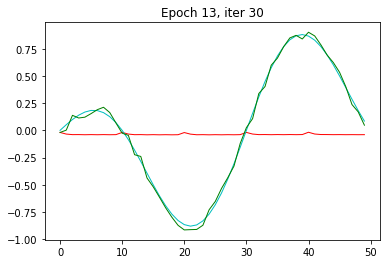

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

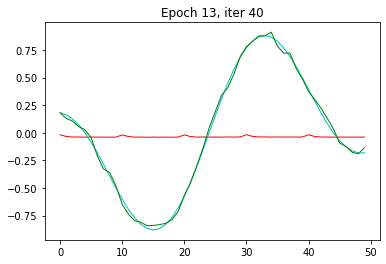

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

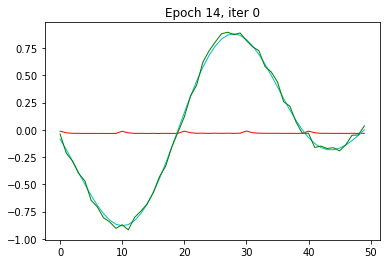

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

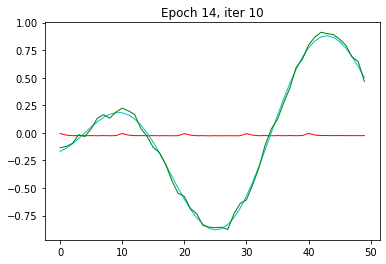

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

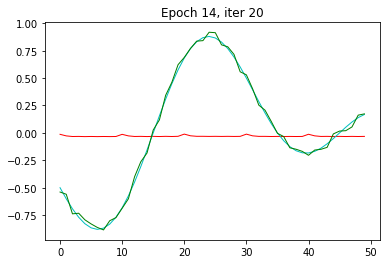

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

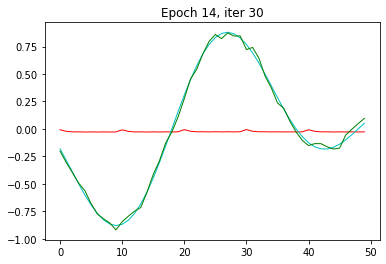

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

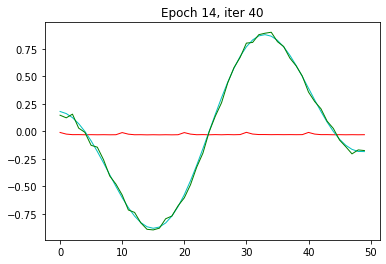

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

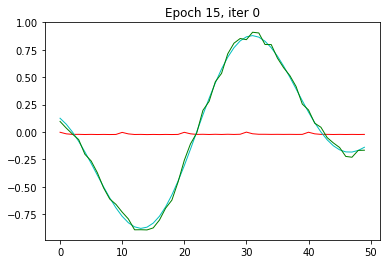

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

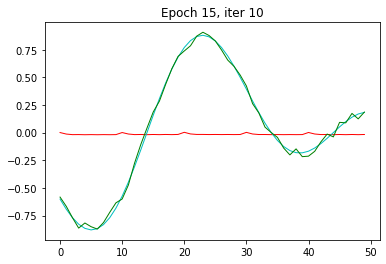

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

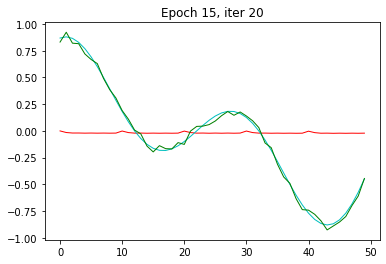

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

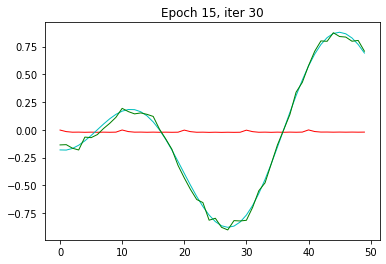

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

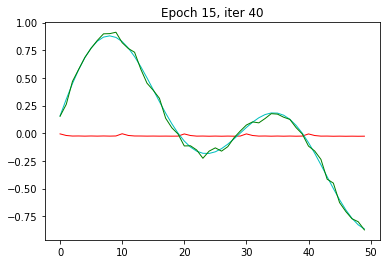

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

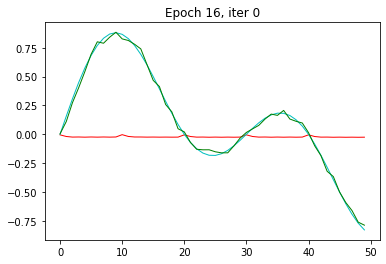

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

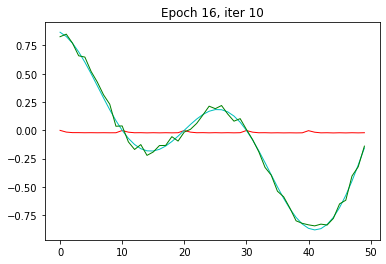

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

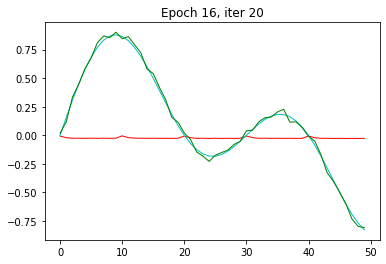

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

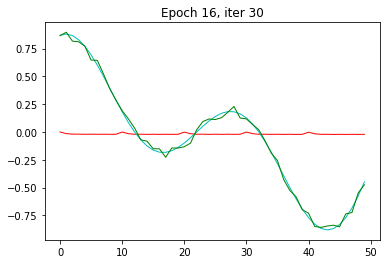

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

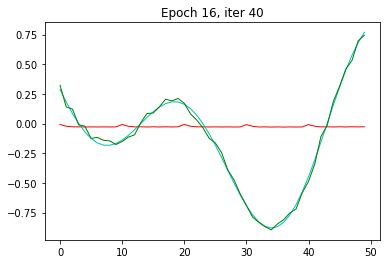

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

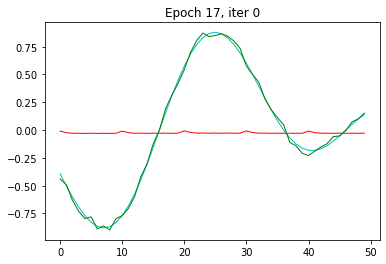

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

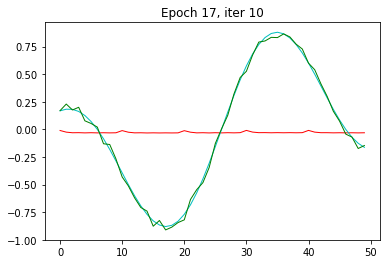

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

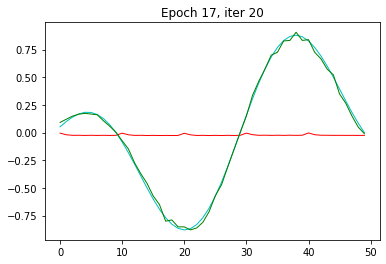

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

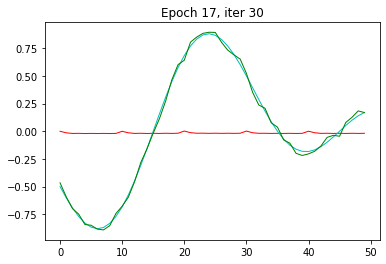

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

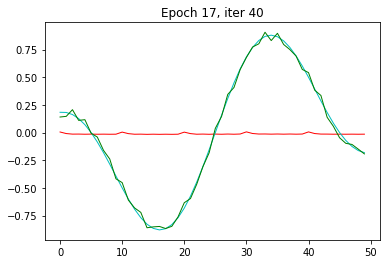

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

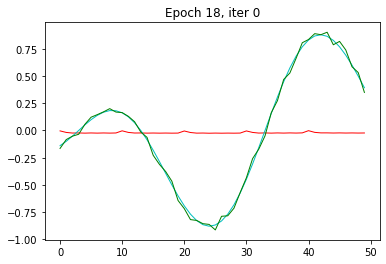

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

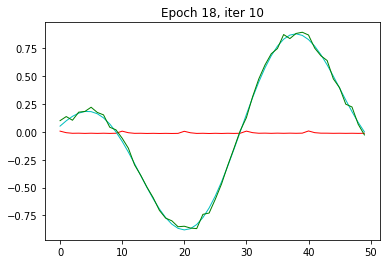

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

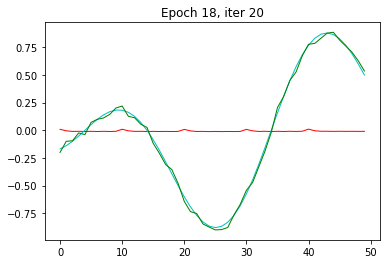

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

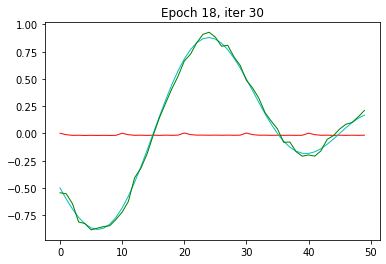

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

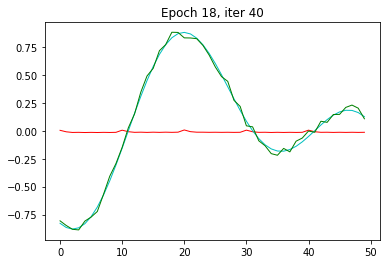

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

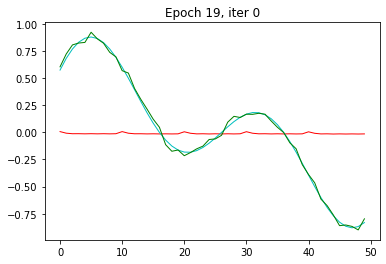

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

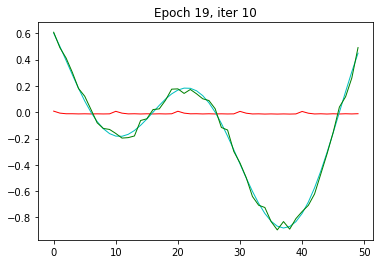

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

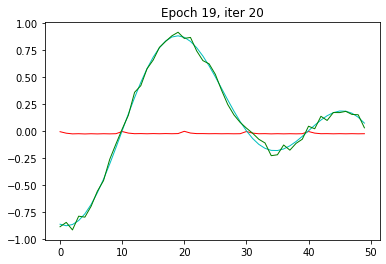

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

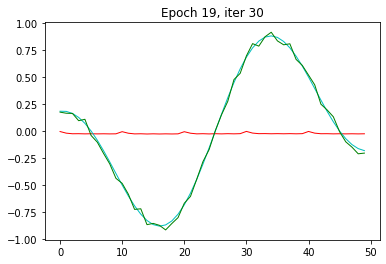

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

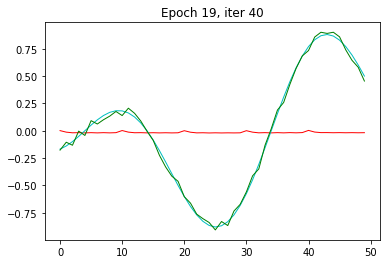

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

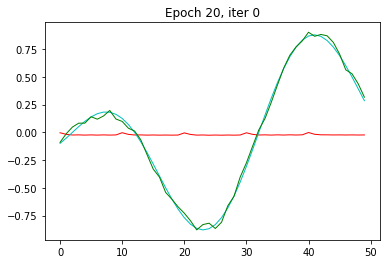

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

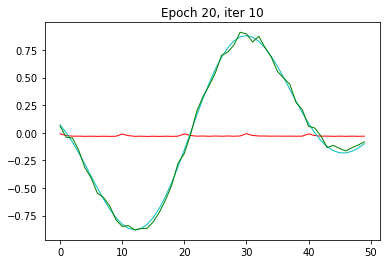

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

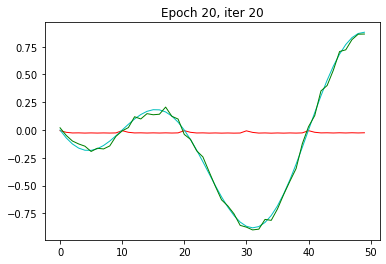

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

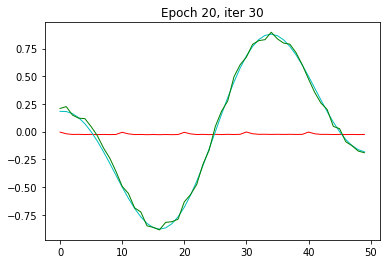

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

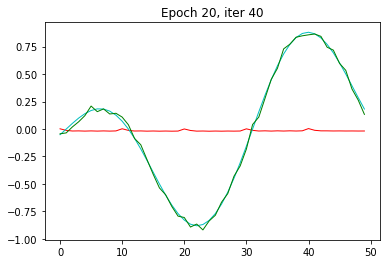

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

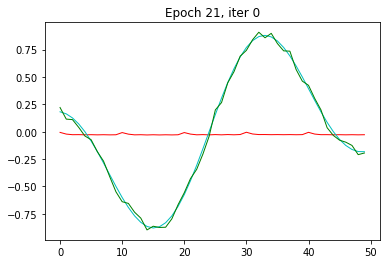

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

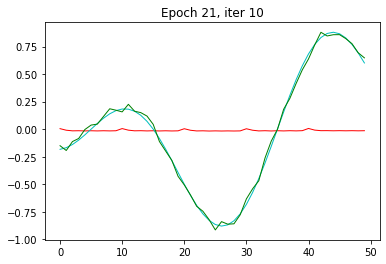

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

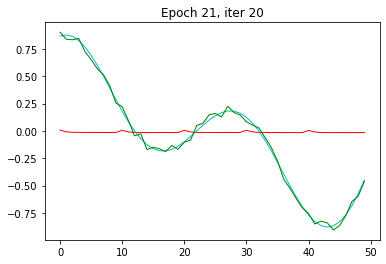

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

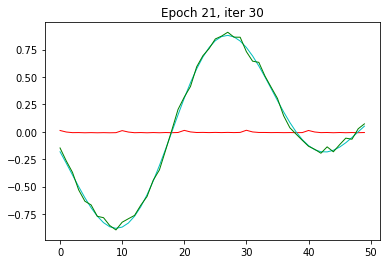

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

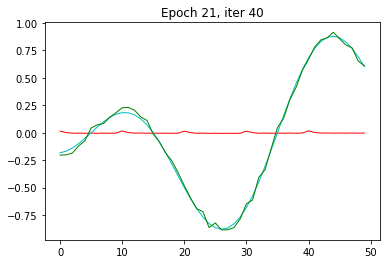

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

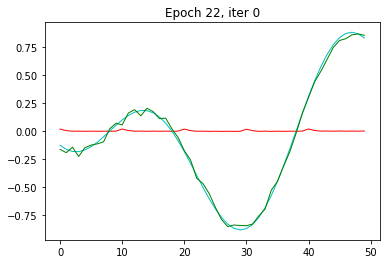

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

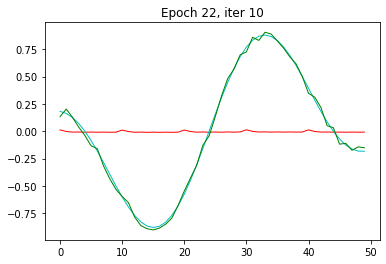

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

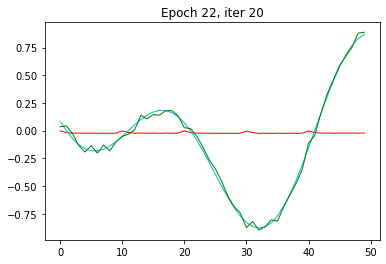

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

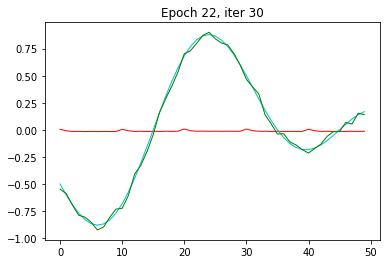

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

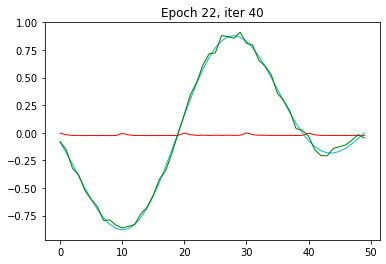

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

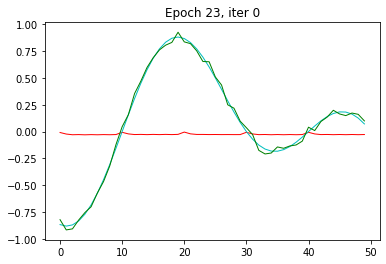

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

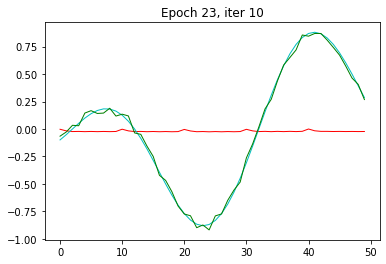

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

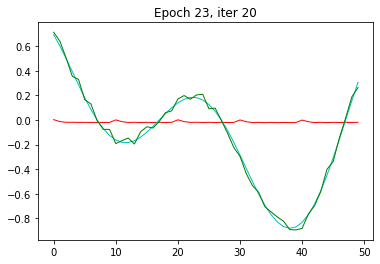

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

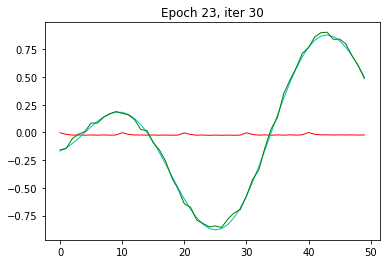

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

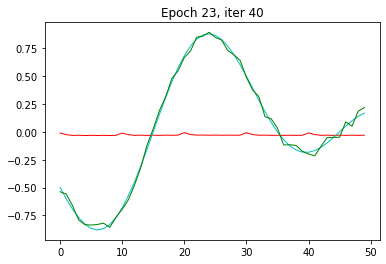

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

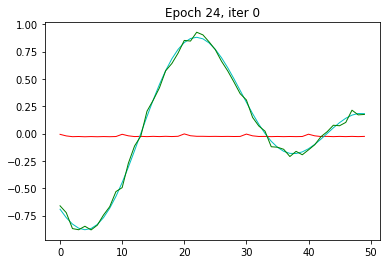

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

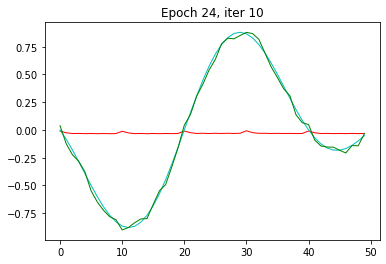

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

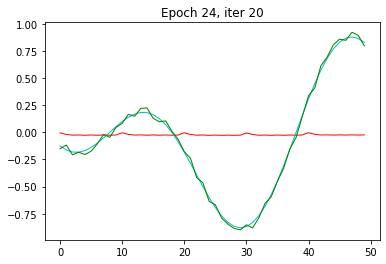

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

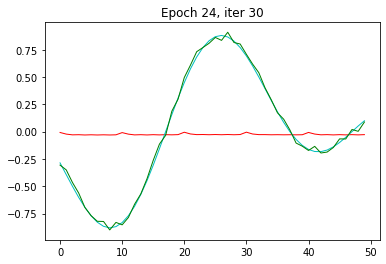

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

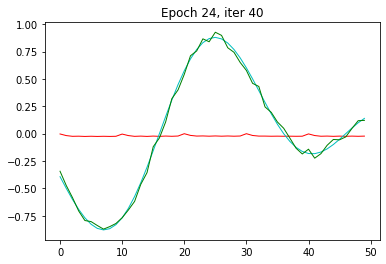

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

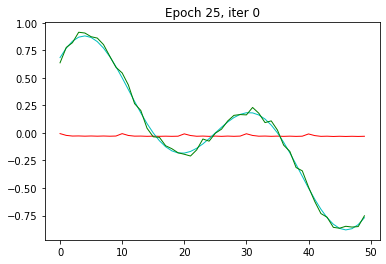

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

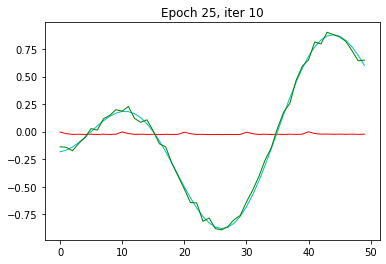

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

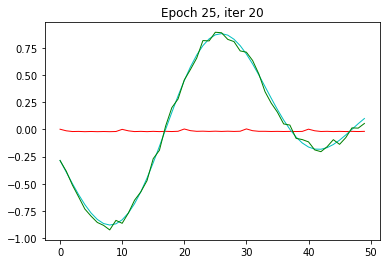

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

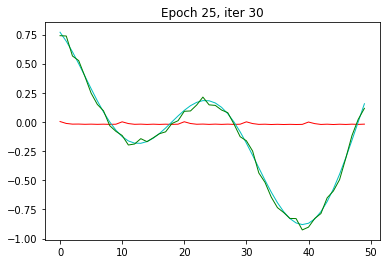

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

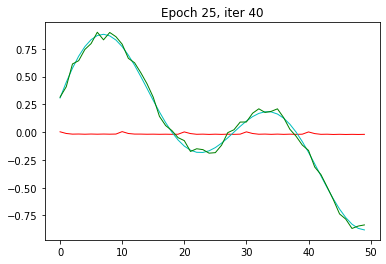

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

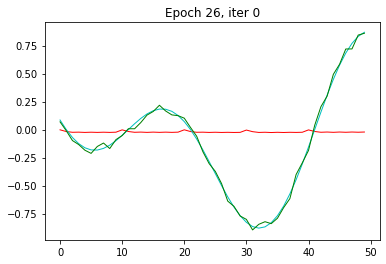

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

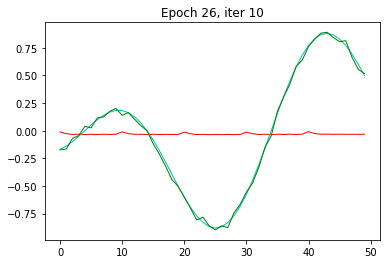

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

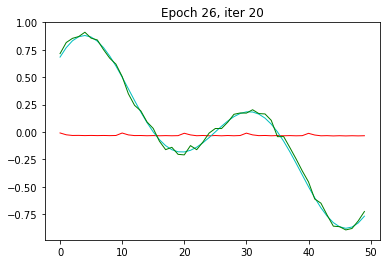

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

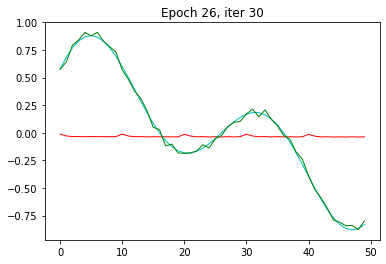

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

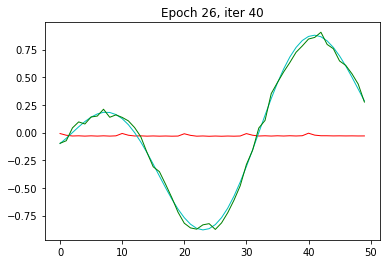

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

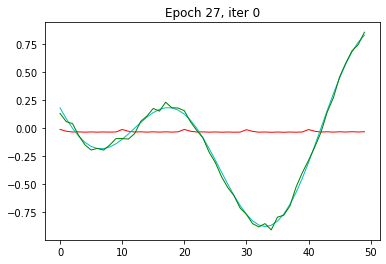

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

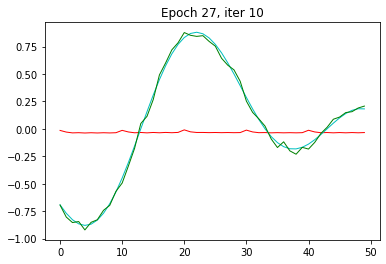

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

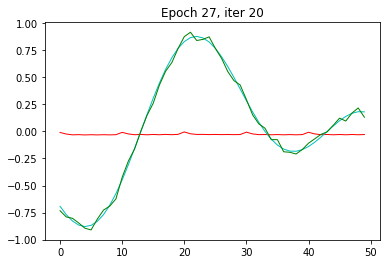

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

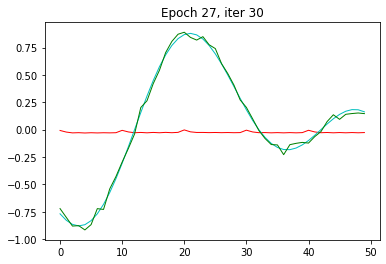

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

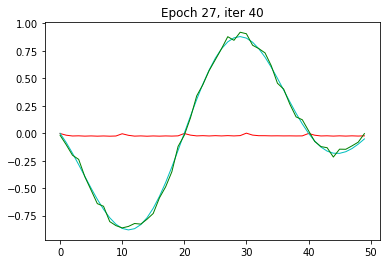

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

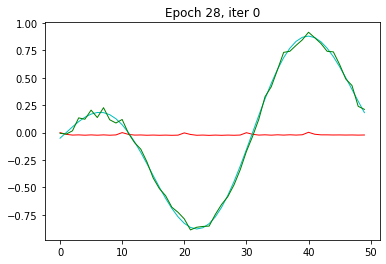

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

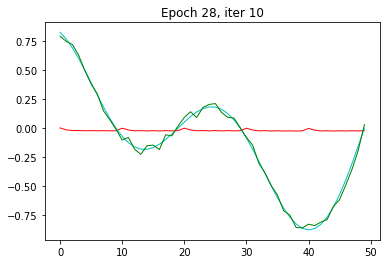

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

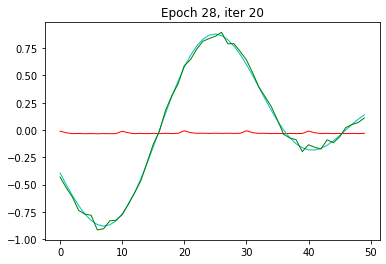

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

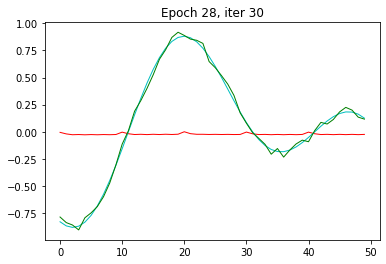

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

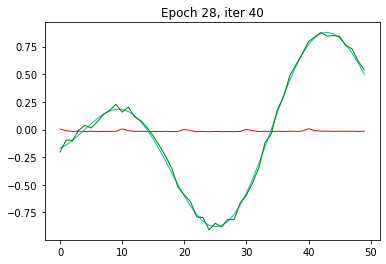

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

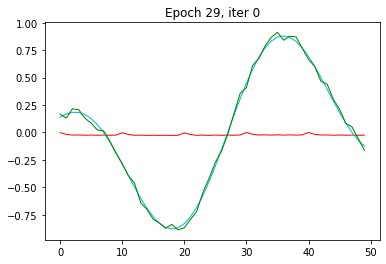

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

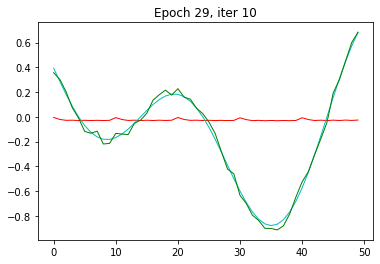

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

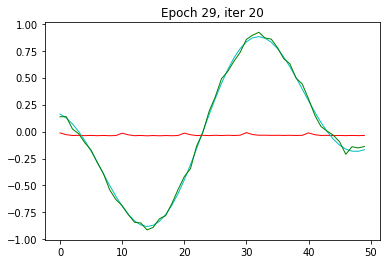

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

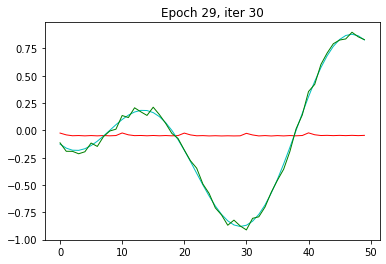

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

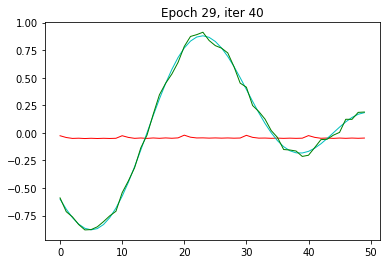

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

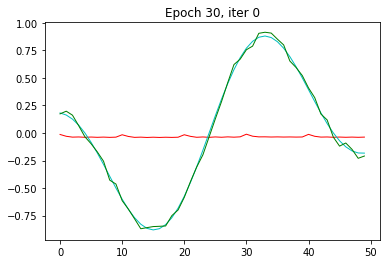

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

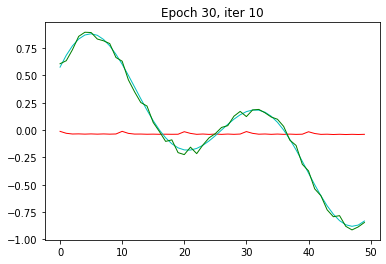

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

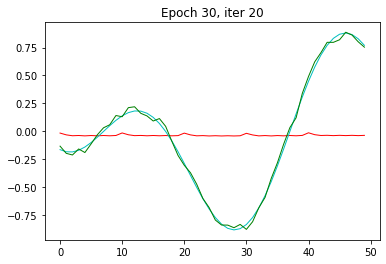

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

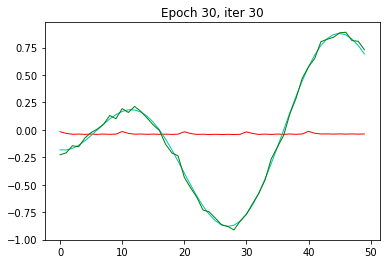

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

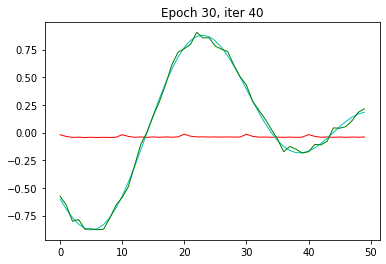

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

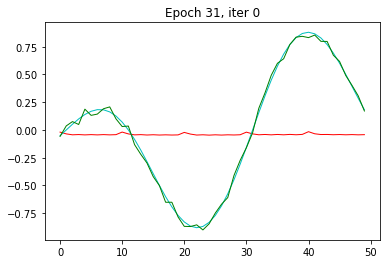

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

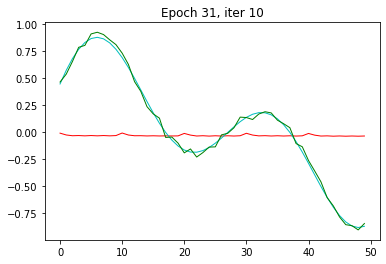

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

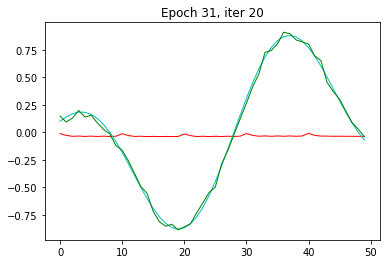

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

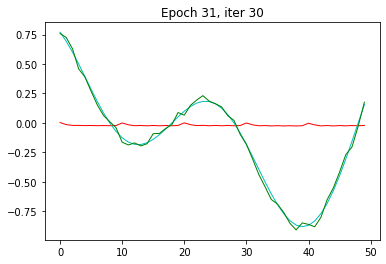

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

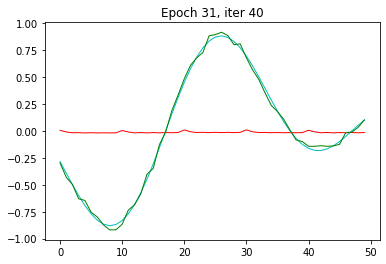

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

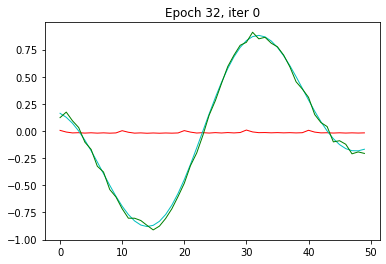

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

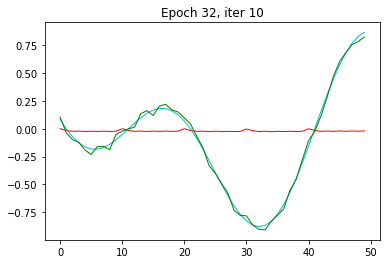

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

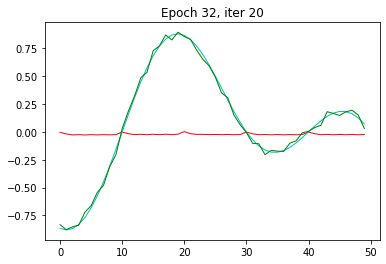

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

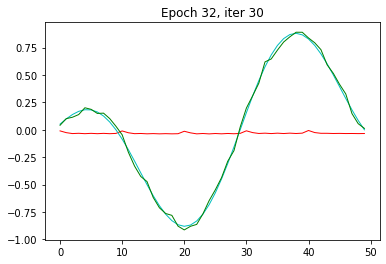

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

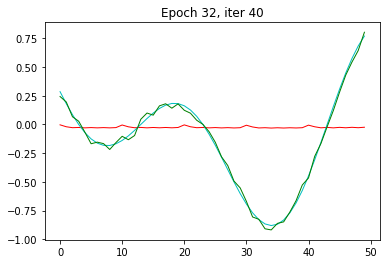

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

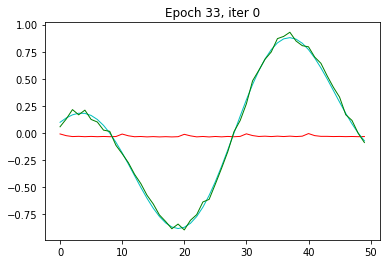

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

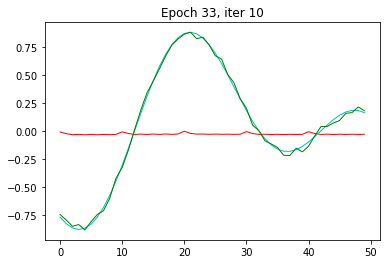

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

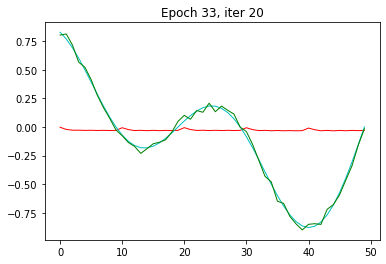

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

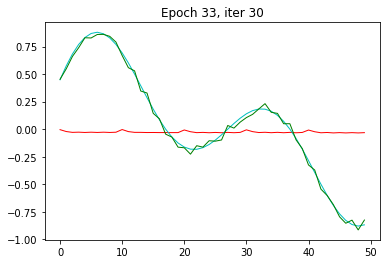

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

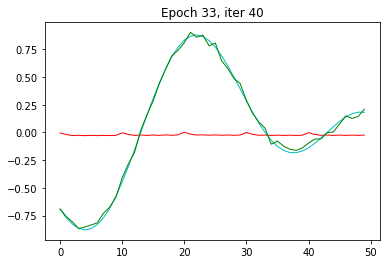

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

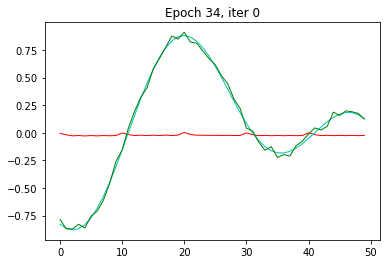

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

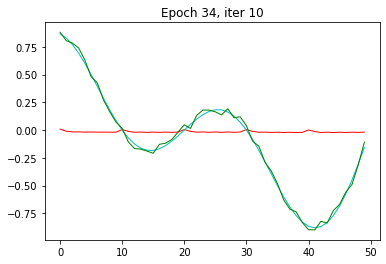

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

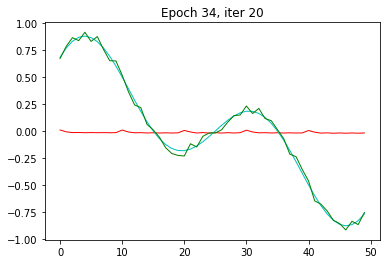

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

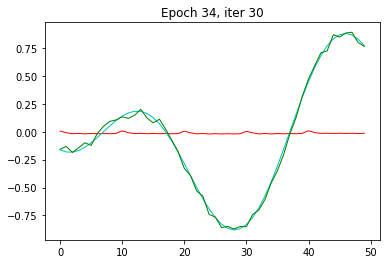

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

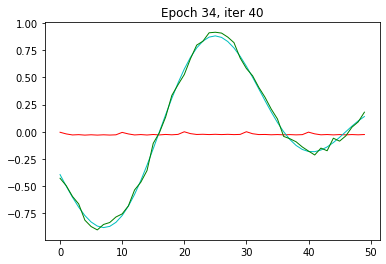

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

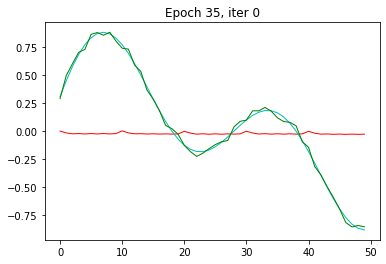

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

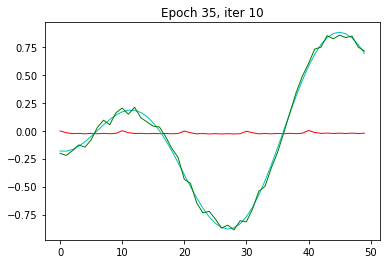

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

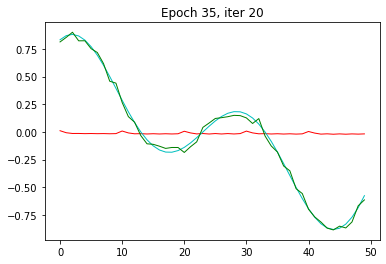

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

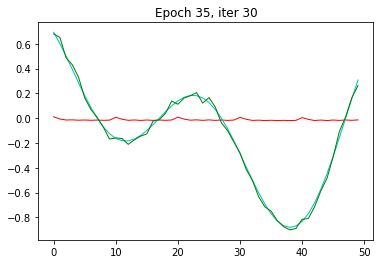

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

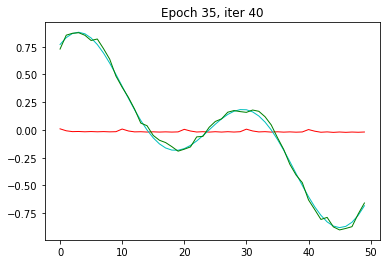

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

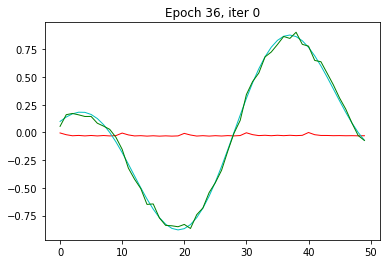

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

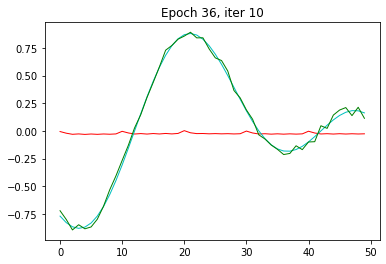

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

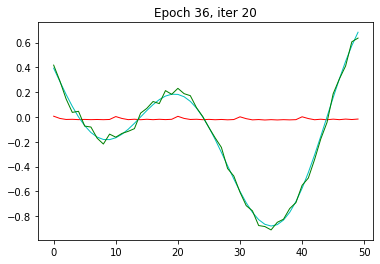

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

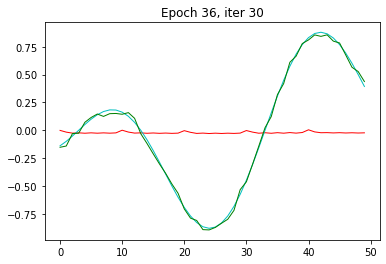

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

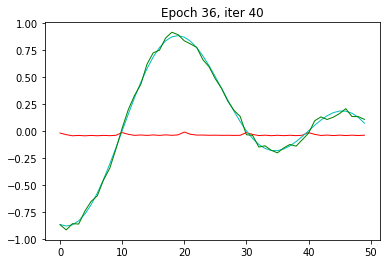

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

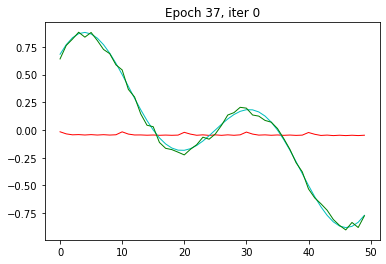

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

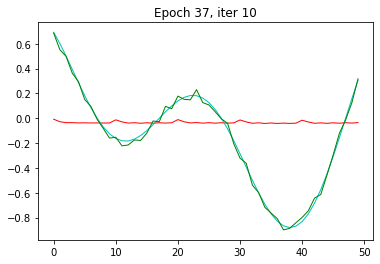

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

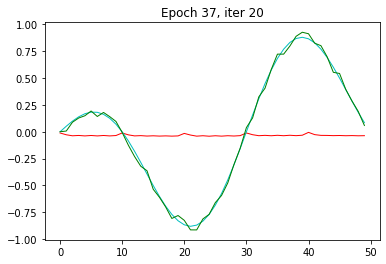

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

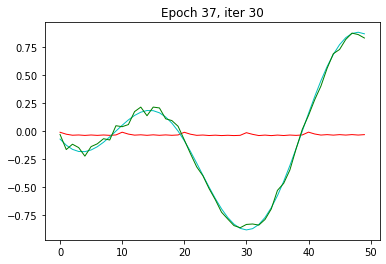

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

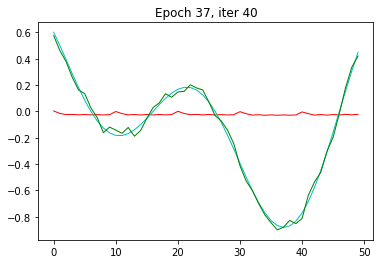

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

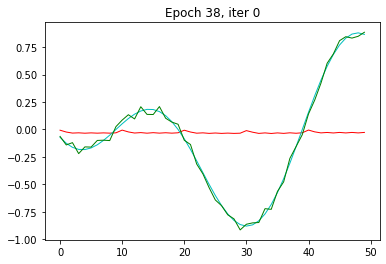

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

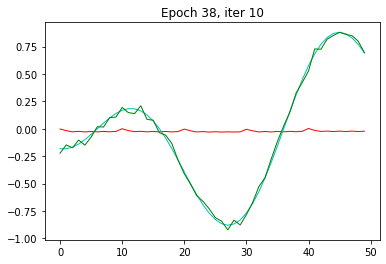

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

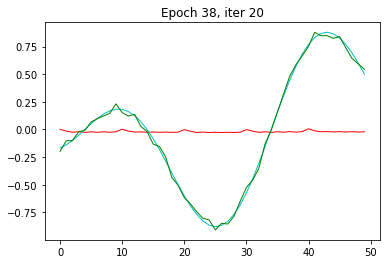

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

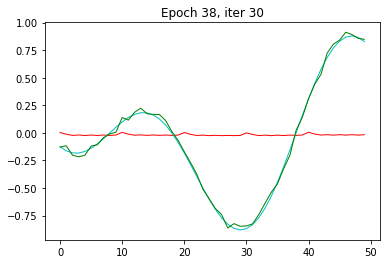

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

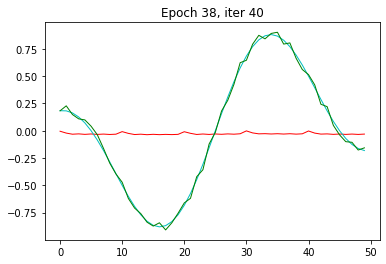

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

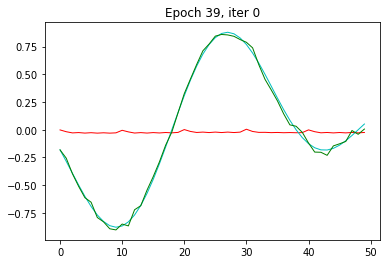

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

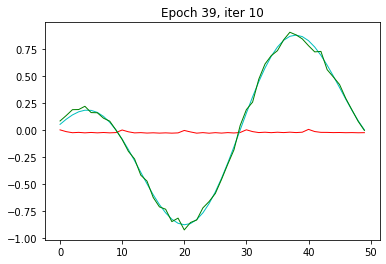

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

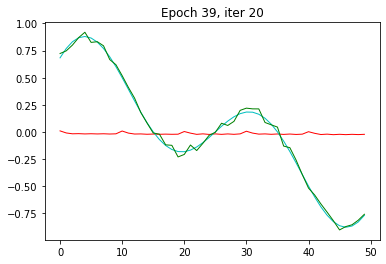

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

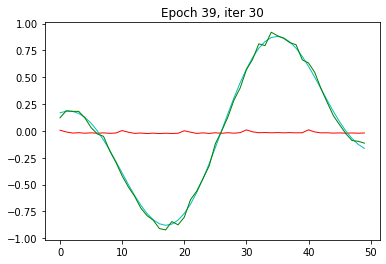

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

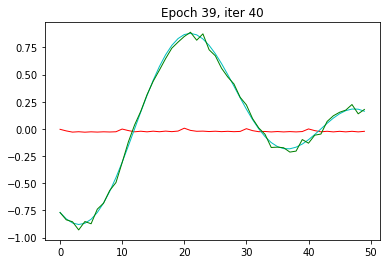

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

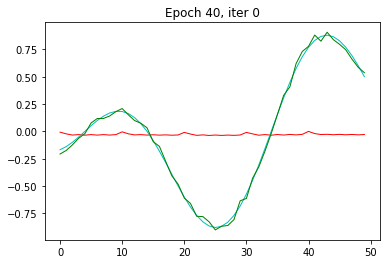

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

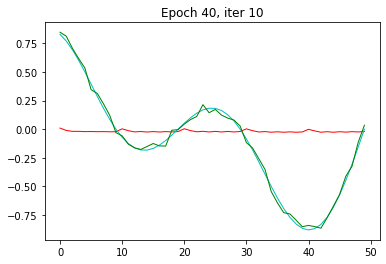

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

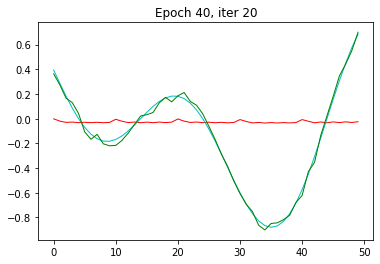

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

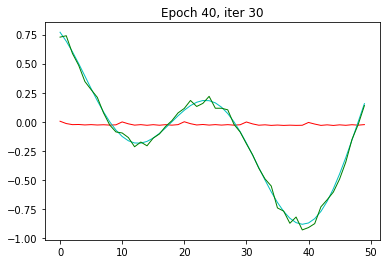

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

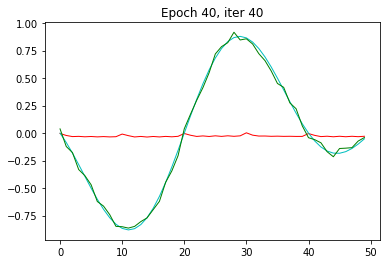

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

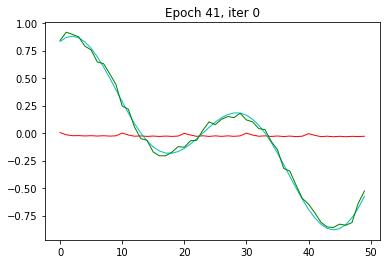

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

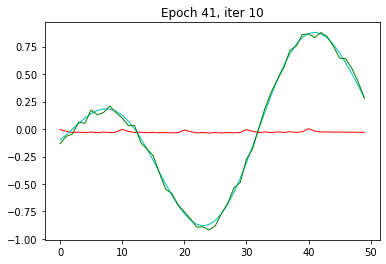

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

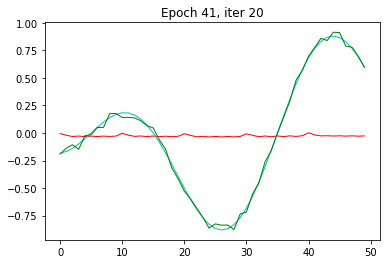

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

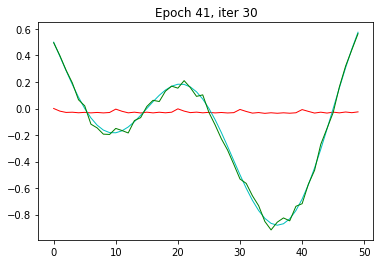

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

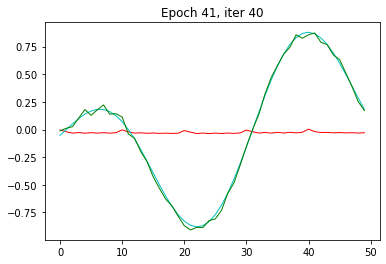

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

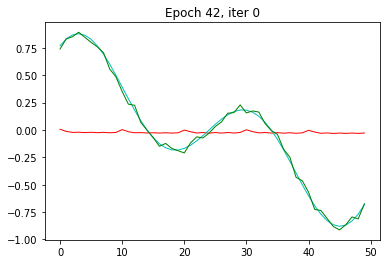

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

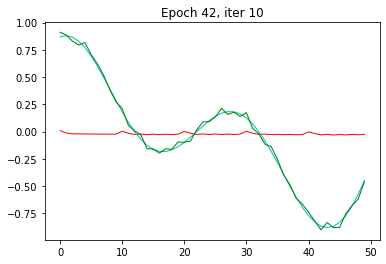

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

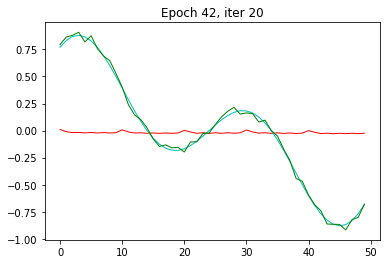

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

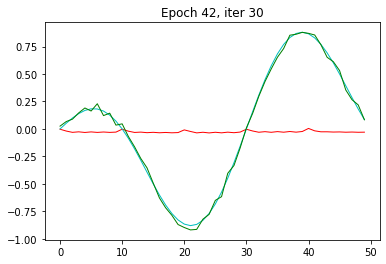

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

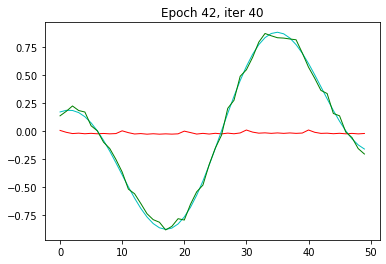

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

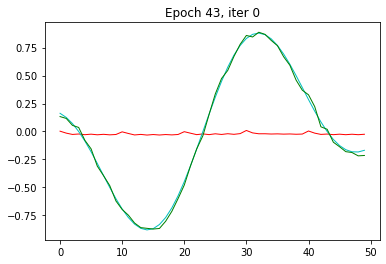

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

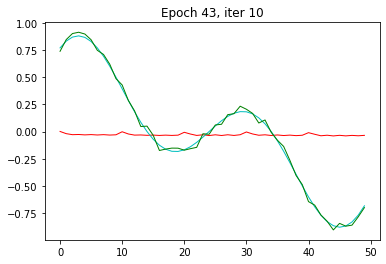

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

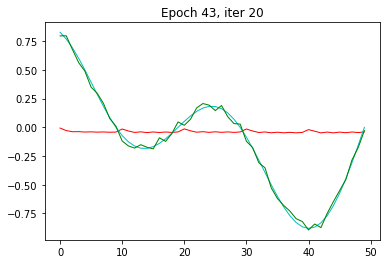

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

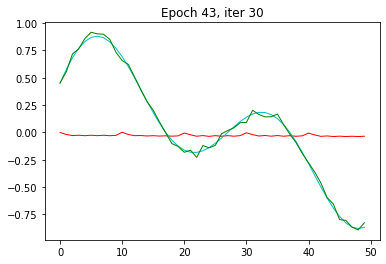

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

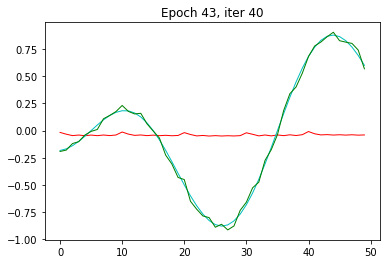

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

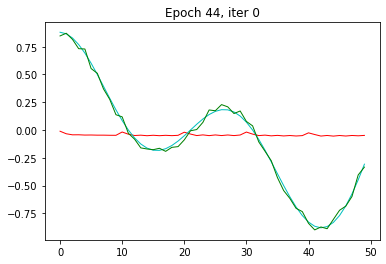

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

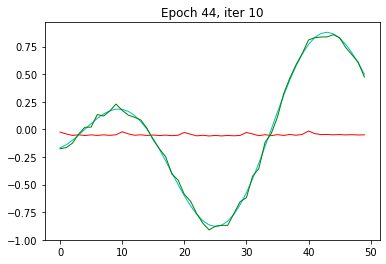

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

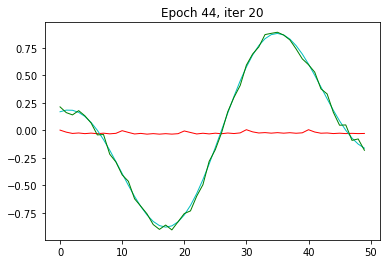

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

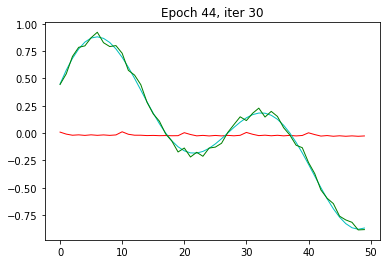

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

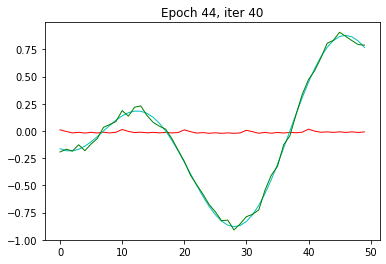

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

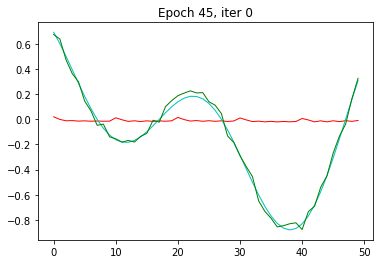

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

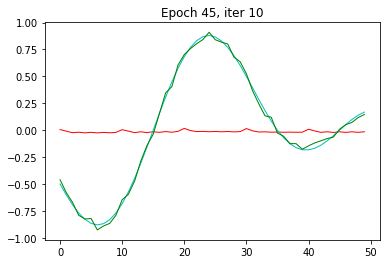

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

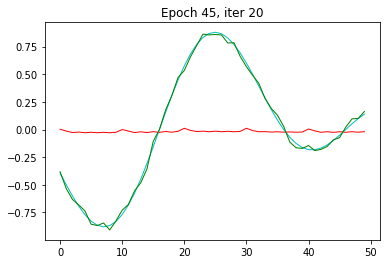

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

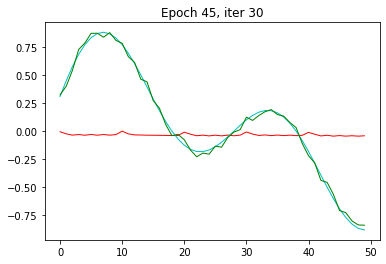

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

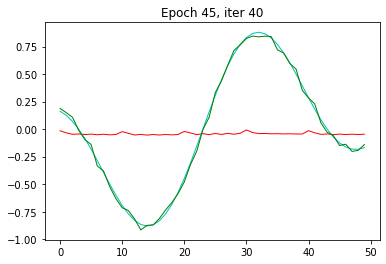

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

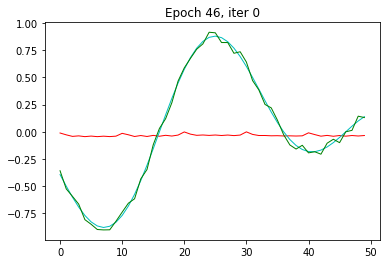

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

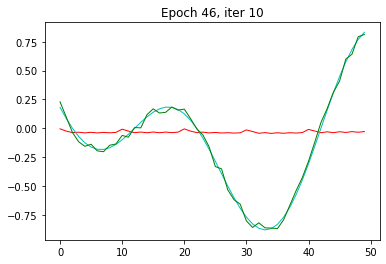

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

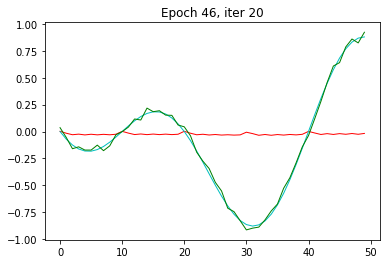

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

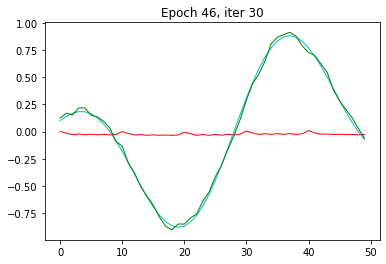

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

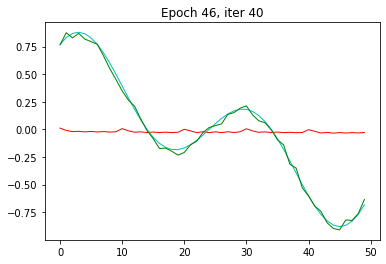

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

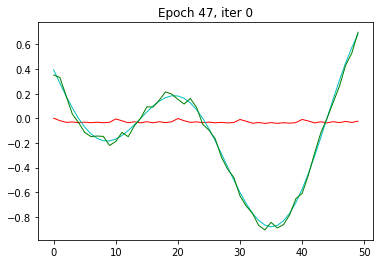

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

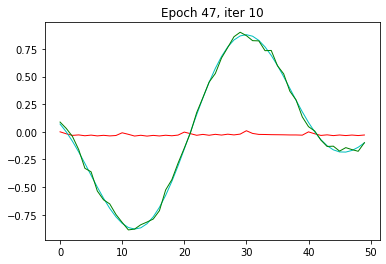

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

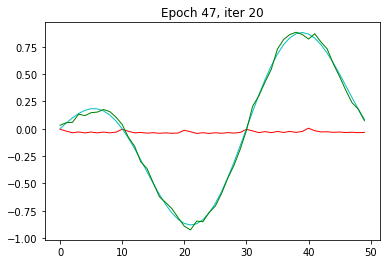

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

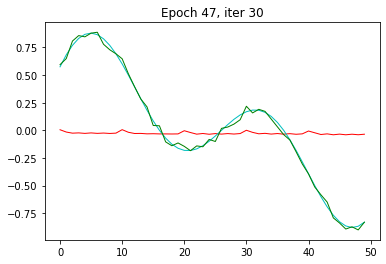

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

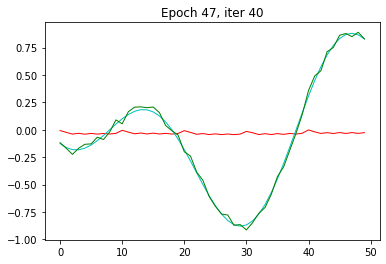

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

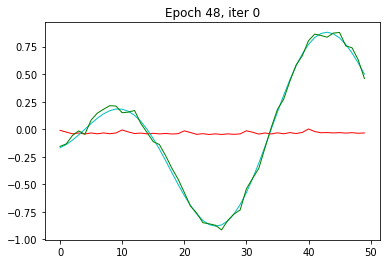

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

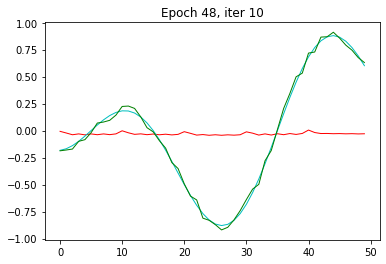

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

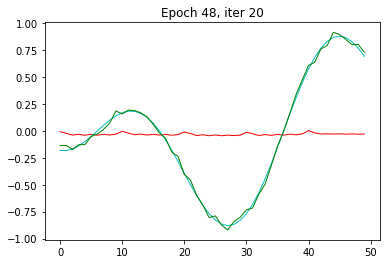

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

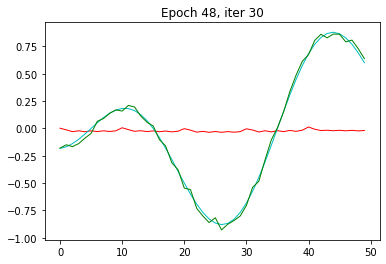

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

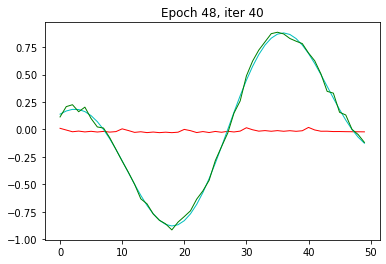

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

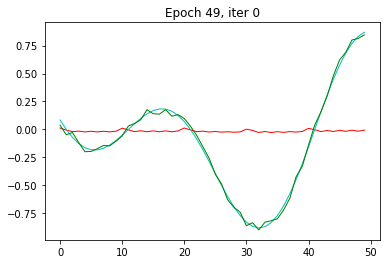

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

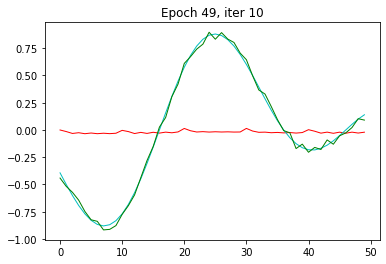

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

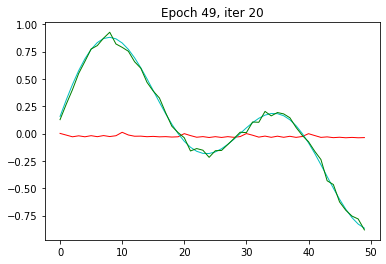

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

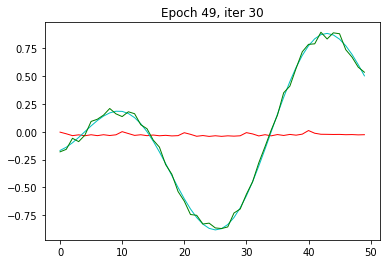

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

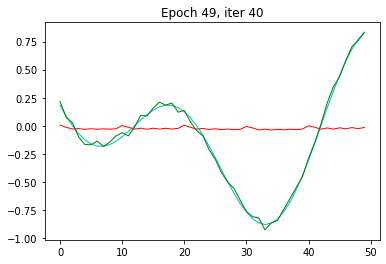

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

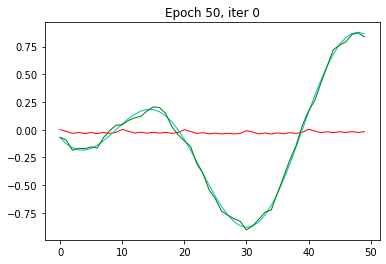

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

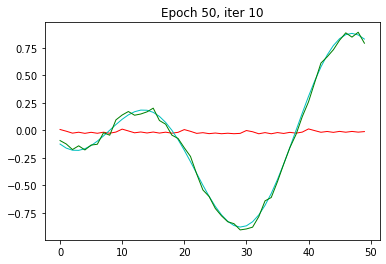

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

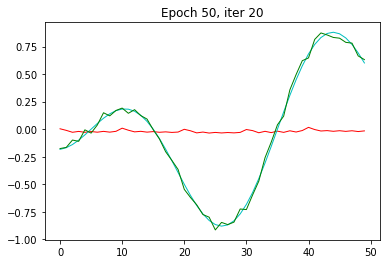

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

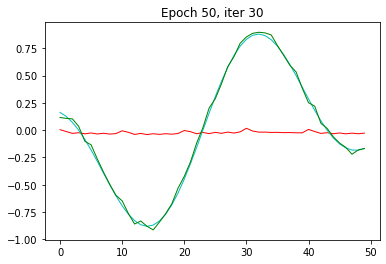

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

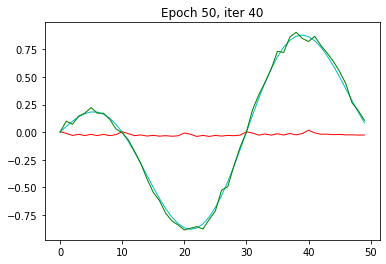

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

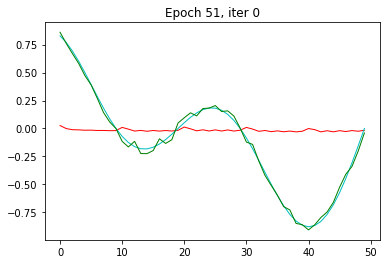

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

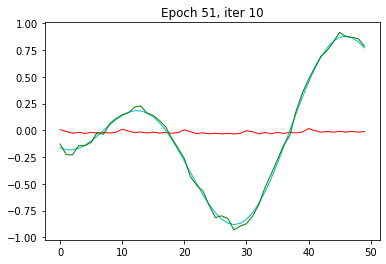

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

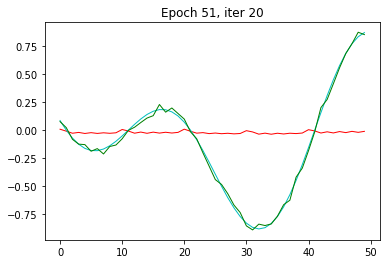

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

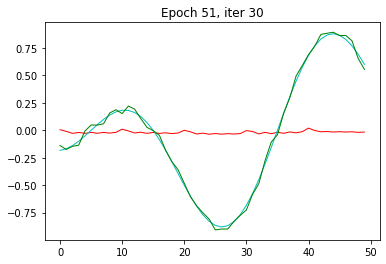

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

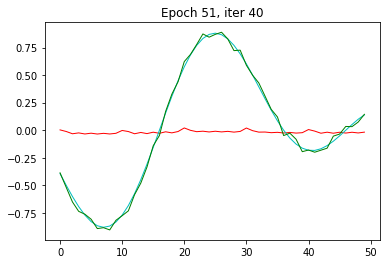

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

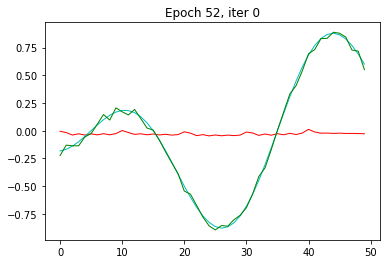

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

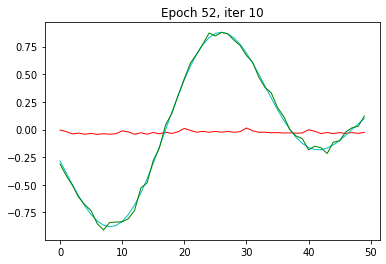

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

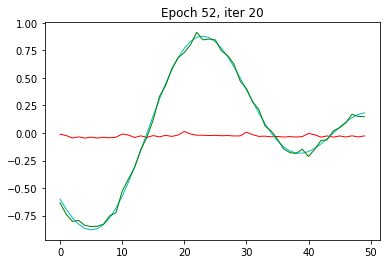

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

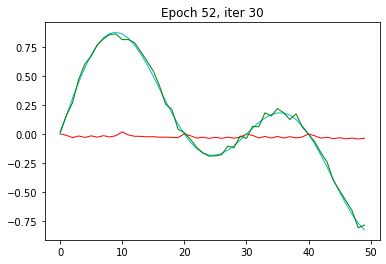

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

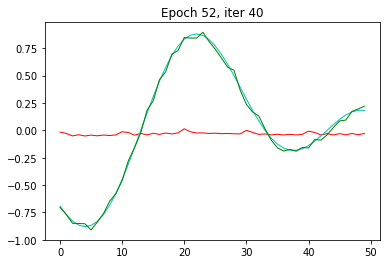

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

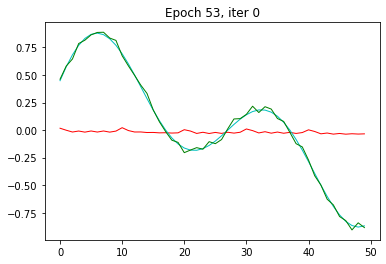

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

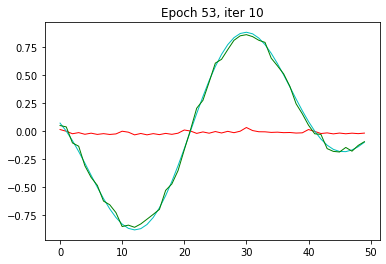

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

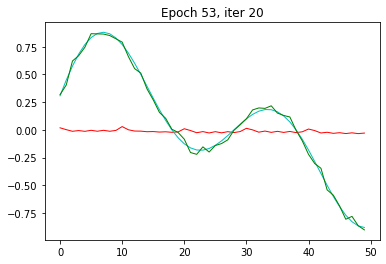

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

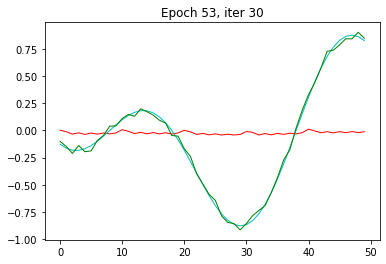

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

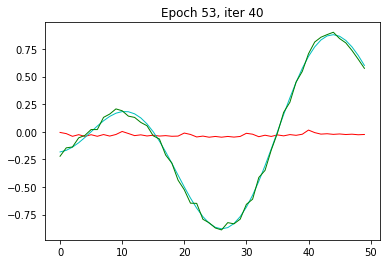

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

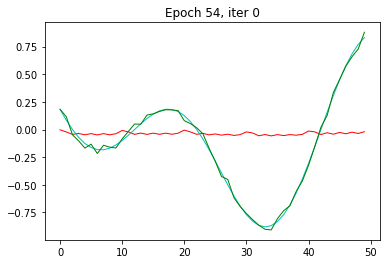

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

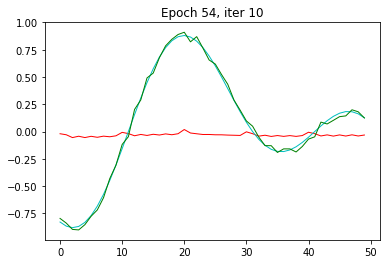

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

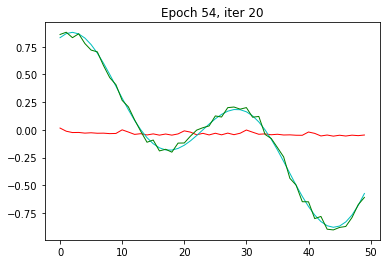

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

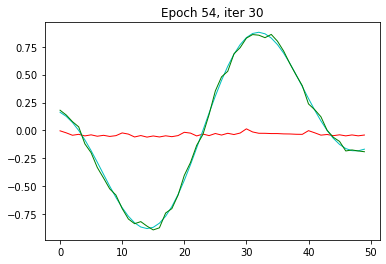

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

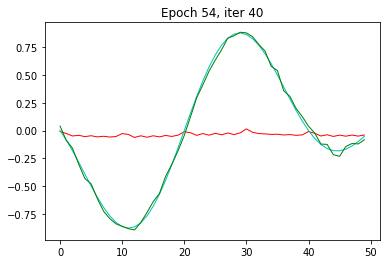

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

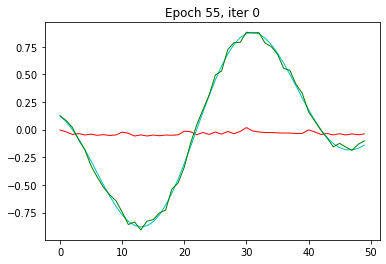

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

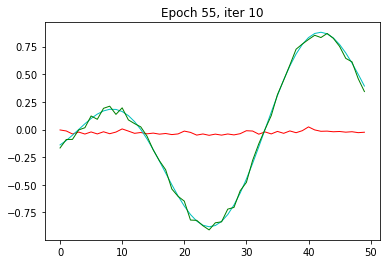

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

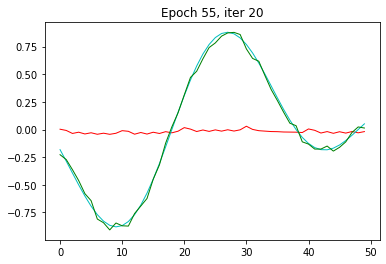

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

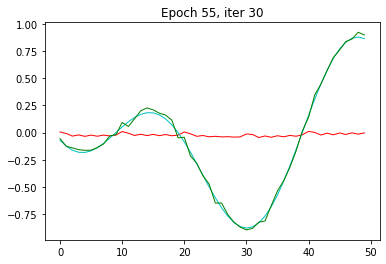

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

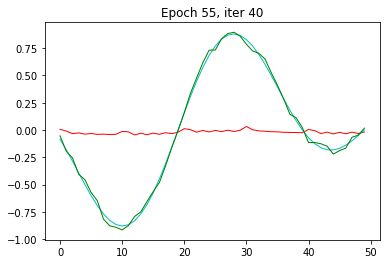

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

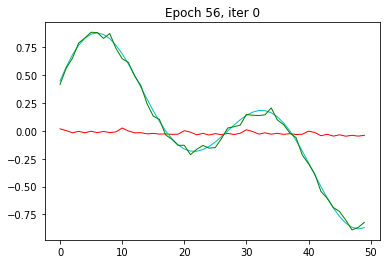

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

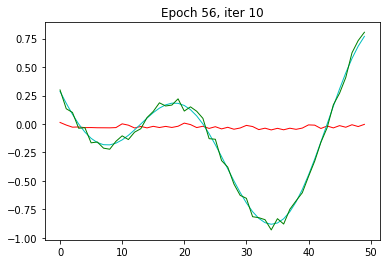

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

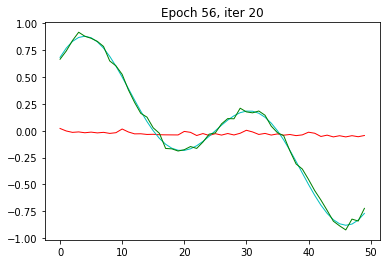

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

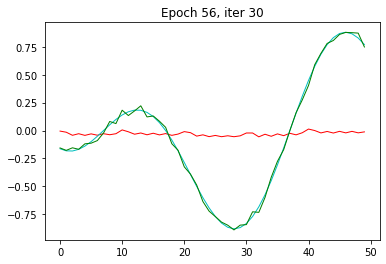

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

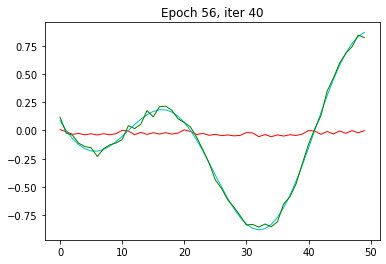

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

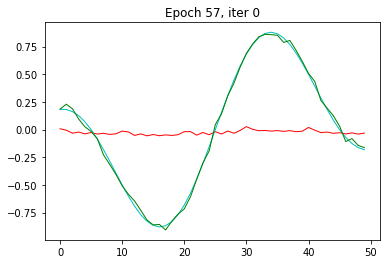

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

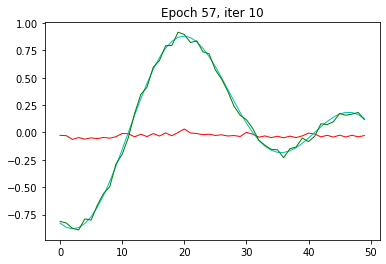

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

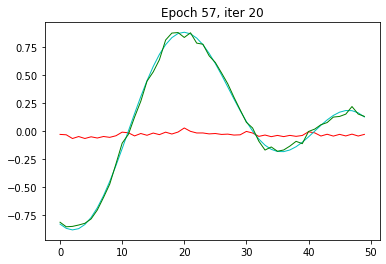

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

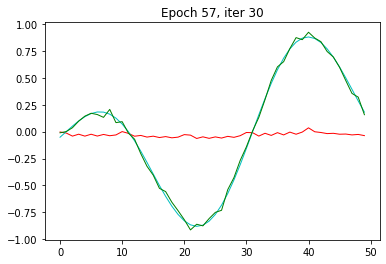

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

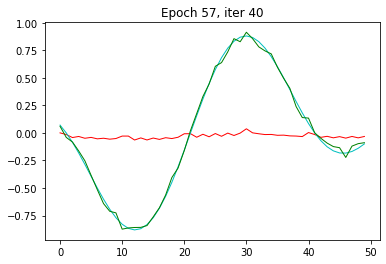

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

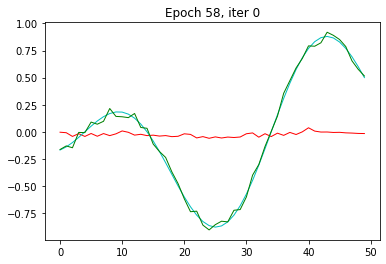

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

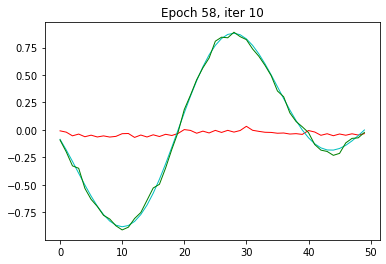

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

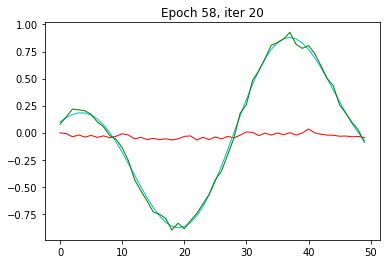

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

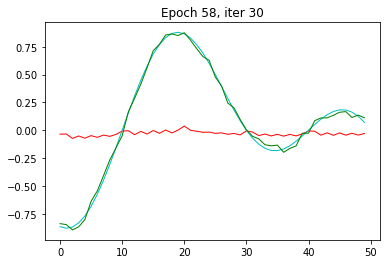

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

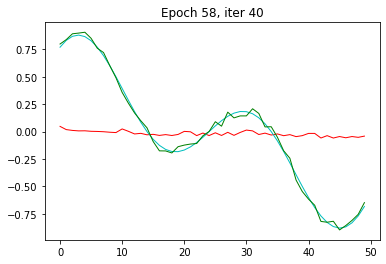

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

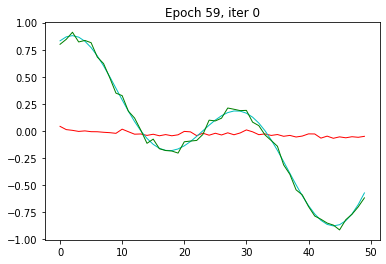

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

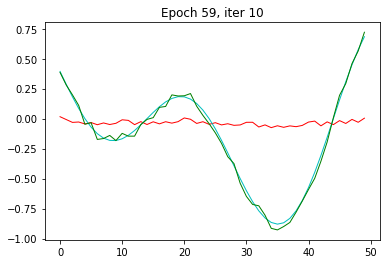

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

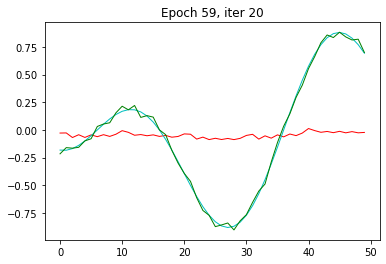

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

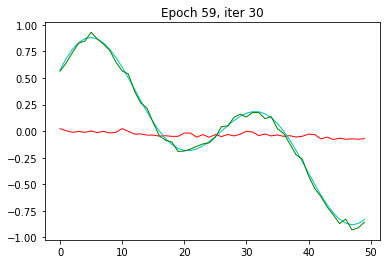

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

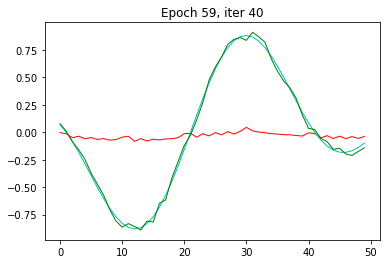

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

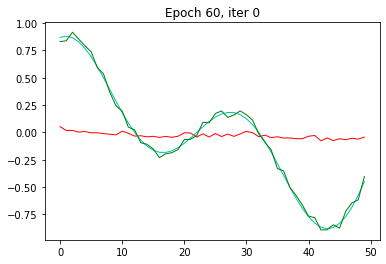

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

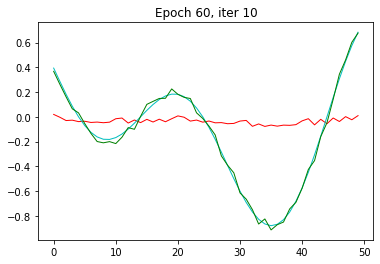

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

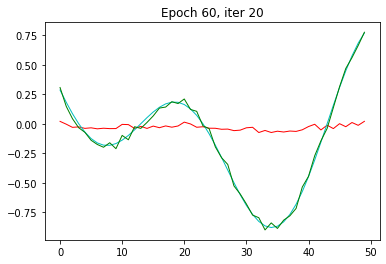

Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5, 10, 1])
Inputs torch.Size([5, 10, 1]), targets torch.Size([5, 10, 1])
Forward hidden torch.Size([2, 5, 1])
Forward inps torch.Size([5, 10, 1])
Out1 torch.Size([5, 10, 1])
Forward outputs torch.Size([5

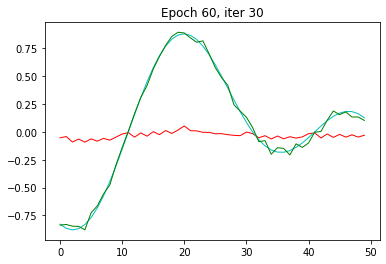

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
import numpy as np
import math, random
import matplotlib.pyplot as plt
# Generating a noisy multi-sin wave 

def sine_2(X, signal_freq=60.):
    return (np.sin(2 * np.pi * (X) / signal_freq) + np.sin(4 * np.pi * (X) / signal_freq)) / 2.0

def noisy(Y, noise_range=(-0.05, 0.05)):
    noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
    return Y + noise

def sample(sample_size):
    random_offset = random.randint(0, sample_size)
    X = np.arange(sample_size)
    x_base = sine_2(X + random_offset)
    Y = noisy(x_base)
    return x_base, Y

# Define the model

class SimpleRNN(nn.Module):
    def __init__(self, hidden_size, n_layers, batch_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.batch_size = batch_size
        #self.inp = nn.Linear(1, hidden_size) 
        self.rnn = nn.RNN(hidden_size, hidden_size, 2, batch_first=True)
        self.out = nn.Linear(hidden_size, hidden_size) # 10 in and 10 out

    def step(self, input, hidden=None):
        #input = self.inp(input.view(1, -1)).unsqueeze(1)
        output, hidden = self.rnn(input, hidden)
        output = self.out(output.squeeze(1))
        return output, hidden

    def forward(self, inputs, hidden=None):
        hidden = self.__init__hidden()
        print("Forward hidden {}".format(hidden.shape))
        print("Forward inps {}".format(inputs.shape))
        output, hidden = self.rnn(inputs.float(), hidden.float())
        print("Out1 {}".format(output.shape))
        output = self.out(output.float());
        print("Forward outputs {}".format(output.shape))

        return output, hidden

    def __init__hidden(self):
       hidden = torch.zeros(self.n_layers, self.batch_size, self.hidden_size, dtype=torch.float64)
       return hidden

n_epochs = 100
n_iters = 50
hidden_size = 1
n_layers = 2
batch_size = 5
seq_length = 10
n_sample_size = 50

model = SimpleRNN(hidden_size, n_layers, int(n_sample_size / seq_length))
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

losses = np.zeros(n_epochs) # For plotting

for epoch in range(n_epochs):

    for iter in range(n_iters):
        _targets, _inputs = sample(n_sample_size)
        inputs = Variable(torch.from_numpy(np.array([_inputs[0:10], _inputs[10:20], _inputs[20:30], _inputs[30:40], _inputs[40:50]], dtype=np.double)).unsqueeze(2));
        targets = Variable(torch.from_numpy(np.array([_targets[0:10], _targets[10:20], _targets[20:30], _targets[30:40], _targets[40:50]], dtype=np.double)).unsqueeze(2).float()) # [49]

        print("Inputs {}, targets {}".format(inputs.shape, targets.shape))
        # Use teacher forcing 50% of the time
        #force = random.random() < 0.5
        outputs, hidden = model(inputs.double(), None)

        optimizer.zero_grad()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        losses[epoch] += loss
        if iter % 10 == 0:
            plt.clf();
            plt.ion()
            plt.title("Epoch {}, iter {}".format(epoch, iter))
            plt.plot(torch.flatten(outputs.detach()),'r-',linewidth=1,label='Output')
            plt.plot(torch.flatten(targets),'c-',linewidth=1,label='Label')
            plt.plot(torch.flatten(inputs),'g-',linewidth=1,label='Input')
            plt.draw();
            plt.pause(0.05);

    if epoch > 0:
        print(epoch, loss)

    # Use some plotting library
    # if epoch % 10 == 0:
        # show_plot('inputs', _inputs, True)
        # show_plot('outputs', outputs.data.view(-1), True)
        # show_plot('losses', losses[:epoch] / n_iters)

        # Generate a test
        # outputs, hidden = model(inputs, False, 50)
        # show_plot('generated', outputs.data.view(-1), True)

# Online training
hidden = None

# while True:
#     inputs = get_latest_sample()
#     outputs, hidden = model(inputs, hidden)

#     optimizer.zero_grad()
#     loss = criterion(outputs, inputs)
#     loss.backward()
#     optimizer.step()
 